In [7]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AffinityPropagation, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import joblib
import statsmodels.api as sm
from itertools import product
import warnings
import folium
from matplotlib.patches import Polygon as Poly
import json
from geojson import Feature, FeatureCollection, Polygon
from scipy import stats
import gc
import pickle
import os
from IPython.display import Image
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\rosas\anaconda3\envs\geo_pandas\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### 1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [2]:
# загрузка аггрегированных значений с 2013 по 2016 гг (по май включительно) по 102 регионам
result_102 = pd.read_csv('result_102.csv', index_col='region')

In [3]:
result_102

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1075                   75.0                108.0                 82.0   
1076                  149.0                204.0                162.0   
1077                   88.0                 81.0                 83.0   
1125                   95.0                126.0                135.0   
1126                  297.0                402.0                361.0   
...                     ...                  ...                  ...   
2068                   19.0                 11.0                  2.0   
2069                    6.0                  3.0                  0.0   
2118                   68.0                 82.0                 28.0   
2119                   18.0                  1.0                  0.0   
2168                   67.0                 15.0                 16.0   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1075                   79.0                 35.0                 13.0   
1076                  122.0                 89.0                 32.0   
1077                   24.0                 20.0                 17.0   
1125                  106.0                 59.0                 19.0   
1126                  289.0                181.0                104.0   
...                     ...                  ...                  ...   
2068                    2.0                  3.0                 26.0   
2069                    0.0                  0.0                  5.0   
2118                    6.0                 30.0                114.0   
2119                    0.0                  2.0                 29.0   
2168                    1.0                 16.0                 70.0   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1075                   15.0                 17.0                 18.0   
1076                   33.0                 37.0                 42.0   
1077                    6.0                 10.0                 13.0   
1125                   13.0                 14.0                 15.0   
1126                   82.0                 74.0                 62.0   
...                     ...                  ...                  ...   
2068                   36.0                 49.0                 19.0   
2069                    5.0                  0.0                  2.0   
2118                   92.0                133.0                 52.0   
2119                   28.0                 25.0                 10.0   
2168                  108.0                 76.0                 71.0   

        2013-01-01 09:00:00  ...  2016-06-30 14:00:00  2016-06-30 15:00:00  \
region                       ...                                             
1075                   32.0  ...                109.0                 86.0   
1076                   47.0  ...                236.0                199.0   
1077                   39.0  ...                103.0                 68.0   
1125                   29.0  ...                107.0                 78.0   
1126                   87.0  ...                212.0                213.0   
...                     ...  ...                  ...                  ...   
2068                    5.0  ...                171.0                141.0   
2069                    1.0  ...                 14.0                  7.0   
2118                   50.0  ...                203.0                169.0   
2119                   16.0  ...                115.0                 98.0   
2168                   81.0  ...                  0.0                  0.0   

        2016-06-30 16:00:00  2016-06-30 17:00:00  2016-06-30 18:00:00  \
region                                                                

In [4]:
result_102_T = result_102.T

In [5]:
result_102_T = result_102_T[:'2016-05-01']

In [6]:
result_102_T

region                1075   1076   1077   1125   1126   1127   1128   1129  \
2013-01-01 00:00:00   75.0  149.0   88.0   95.0  297.0  538.0  594.0  769.0   
2013-01-01 01:00:00  108.0  204.0   81.0  126.0  402.0  572.0  518.0  623.0   
2013-01-01 02:00:00   82.0  162.0   83.0  135.0  361.0  471.0  470.0  495.0   
2013-01-01 03:00:00   79.0  122.0   24.0  106.0  289.0  482.0  448.0  467.0   
2013-01-01 04:00:00   35.0   89.0   20.0   59.0  181.0  332.0  377.0  343.0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2016-04-30 19:00:00  121.0  209.0  145.0  101.0  345.0  445.0  519.0  724.0   
2016-04-30 20:00:00  107.0  208.0   99.0  107.0  290.0  411.0  543.0  733.0   
2016-04-30 21:00:00   91.0  155.0  108.0  115.0  318.0  463.0  600.0  875.0   
2016-04-30 22:00:00  100.0   97.0   85.0  100.0  217.0  421.0  697.0  955.0   
2016-04-30 23:00:00   92.0  118.0   63.0   86.0  284.0  529.0  733.0  838.0   

region                1130   1131  ...  1630  1684  1733   1734  1783   2068  \
2013-01-01 00:00:00  952.0  267.0  ...  12.0   0.0   9.0  113.0  27.0   19.0   
2013-01-01 01:00:00  655.0  220.0  ...  22.0   0.0   3.0    7.0   5.0   11.0   
2013-01-01 02:00:00  484.0  156.0  ...  23.0   0.0   1.0    6.0   3.0    2.0   
2013-01-01 03:00:00  337.0  102.0  ...  25.0   0.0   1.0    1.0   7.0    2.0   
2013-01-01 04:00:00  354.0   92.0  ...  26.0   0.0   2.0    5.0   2.0    3.0   
...                    ...    ...  ...   ...   ...   ...    ...   ...    ...   
2016-04-30 19:00:00  817.0  244.0  ...   1.0   0.0   5.0  152.0  83.0  140.0   
2016-04-30 20:00:00  840.0  210.0  ...   2.0   0.0   2.0  141.0  41.0  119.0   
2016-04-30 21:00:00  831.0  152.0  ...   2.0   0.0   2.0  190.0  67.0  129.0   
2016-04-30 22:00:00  909.0  203.0  ...   1.0   0.0   2.0  230.0  80.0  132.0   
2016-04-30 23:00:00  918.0  185.0  ...   4.0   0.0   0.0  195.0  54.0  134.0   

region               2069   2118  2119   2168  
2013-01-01 00:00:00   6.0   68.0  18.0   67.0  
2013-01-01 01:00:00   3.0   82.0   1.0   15.0  
2013-01-01 02:00:00   0.0   28.0   0.0   16.0  
2013-01-01 03:00:00   0.0    6.0   0.0    1.0  
2013-01-01 04:00:00   0.0   30.0   2.0   16.0  
...                   ...    ...   ...    ...  
2016-04-30 19:00:00   5.0  158.0  59.0   84.0  
2016-04-30 20:00:00  11.0  232.0  50.0  120.0  
2016-04-30 21:00:00  16.0  158.0  81.0  117.0  
2016-04-30 22:00:00  21.0  198.0  23.0   93.0  
2016-04-30 23:00:00  10.0  181.0  74.0   39.0  

[29182 rows x 102 columns]

#### 2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [7]:
result_102_T.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29182 entries, 2013-01-01 00:00:00 to 2016-04-30 23:00:00
Columns: 102 entries, 1075 to 2168
dtypes: float64(102)
memory usage: 22.9+ MB


In [8]:
# Стандартизация регионов
scaler = StandardScaler()
res_sc = scaler.fit_transform(result_102_T.values)

In [9]:
res_sc = pd.DataFrame(res_sc, index=result_102_T.index, columns=result_102_T.columns)

In [10]:
res_sc

region                   1075      1076      1077      1125      1126  \
2013-01-01 00:00:00  0.222679  0.100211 -0.108691  0.498090  0.793513   
2013-01-01 01:00:00  1.016254  0.755825 -0.214710  1.220335  1.739180   
2013-01-01 02:00:00  0.391013  0.255174 -0.184419  1.430019  1.369920   
2013-01-01 03:00:00  0.318870 -0.221636 -1.078009  0.754370  0.721463   
2013-01-01 04:00:00 -0.739230 -0.615004 -1.138592 -0.340647 -0.251223   
...                       ...       ...       ...       ...       ...   
2016-04-30 19:00:00  1.328874  0.815427  0.754608  0.637879  1.225818   
2016-04-30 20:00:00  0.992206  0.803506  0.057911  0.777669  0.730469   
2016-04-30 21:00:00  0.607443  0.171733  0.194221  0.964055  0.982647   
2016-04-30 22:00:00  0.823872 -0.519642 -0.154128  0.614581  0.073005   
2016-04-30 23:00:00  0.631490 -0.269317 -0.487331  0.288406  0.676431   

region                   1127      1128      1129      1130      1131  ...  \
2013-01-01 00:00:00  1.272384  1.113618  1.515722  1.670000  1.189513  ...   
2013-01-01 01:00:00  1.469364  0.748738  0.901776  0.623150  0.667852  ...   
2013-01-01 02:00:00  0.884219  0.518287  0.363522  0.020418 -0.042495  ...   
2013-01-01 03:00:00  0.947947  0.412664  0.245779 -0.497720 -0.641851  ...   
2013-01-01 04:00:00  0.078920  0.071789 -0.275655 -0.437799 -0.752843  ...   
...                       ...       ...       ...       ...       ...  ...   
2016-04-30 19:00:00  0.733587  0.753539  1.326492  1.194159  0.934232  ...   
2016-04-30 20:00:00  0.536608  0.868764  1.364338  1.275228  0.556860  ...   
2016-04-30 21:00:00  0.837871  1.142425  1.961464  1.243506 -0.086892  ...   
2016-04-30 22:00:00  0.594543  1.608127  2.297873  1.518436  0.479166  ...   
2016-04-30 23:00:00  1.220243  1.780965  1.805875  1.550159  0.279381  ...   

region                   1630      1684      1733      1734      1783  \
2013-01-01 00:00:00  1.297400 -0.877373  0.038294 -0.598009 -1.081844   
2013-01-01 01:00:00  3.318320 -0.877373 -0.798566 -1.278594 -1.247978   
2013-01-01 02:00:00  3.520412 -0.877373 -1.077519 -1.285015 -1.263081   
2013-01-01 03:00:00  3.924596 -0.877373 -1.077519 -1.317118 -1.232875   
2013-01-01 04:00:00  4.126688 -0.877373 -0.938042 -1.291435 -1.270633   
...                       ...       ...       ...       ...       ...   
2016-04-30 19:00:00 -0.925612 -0.877373 -0.519612 -0.347605 -0.658956   
2016-04-30 20:00:00 -0.723520 -0.877373 -0.938042 -0.418232 -0.976122   
2016-04-30 21:00:00 -0.723520 -0.877373 -0.938042 -0.103622 -0.779781   
2016-04-30 22:00:00 -0.925612 -0.877373 -0.938042  0.153202 -0.681611   
2016-04-30 23:00:00 -0.319336 -0.877373 -1.216995 -0.071519 -0.877952   

region                   2068      2069      2118      2119      2168  
2013-01-01 00:00:00 -1.104653 -0.344677 -0.833240 -0.731489  0.276530  
2013-01-01 01:00:00 -1.248424 -0.716314 -0.644890 -1.255876 -1.209317  
2013-01-01 02:00:00 -1.410166 -1.087951 -1.371383 -1.286722 -1.180743  
2013-01-01 03:00:00 -1.410166 -1.087951 -1.667362 -1.286722 -1.609353  
2013-01-01 04:00:00 -1.392195 -1.087951 -1.344476 -1.225029 -1.180743  
...                       ...       ...       ...       ...       ...  
2016-04-30 19:00:00  1.069882 -0.468556  0.377582  0.533207  0.762288  
2016-04-30 20:00:00  0.692483  0.274718  1.373146  0.255591  1.790951  
2016-04-30 21:00:00  0.872197  0.894114  0.377582  1.211825  1.705229  
2016-04-30 22:00:00  0.926111  1.513509  0.915725 -0.577258  1.019453  
2016-04-30 23:00:00  0.962053  0.150839  0.687014  0.995901 -0.523542  

[29182 rows x 102 columns]

In [11]:
res_sc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29182 entries, 2013-01-01 00:00:00 to 2016-04-30 23:00:00
Columns: 102 entries, 1075 to 2168
dtypes: float64(102)
memory usage: 22.9+ MB


In [12]:
# Проверка на всякий случай на NAN
res_sc.isnull().sum()

region
1075    0
1076    0
1077    0
1125    0
1126    0
       ..
2068    0
2069    0
2118    0
2119    0
2168    0
Length: 102, dtype: int64

#### 3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

In [13]:
res_sc = res_sc.T 
res_sc

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1075               0.222679             1.016254             0.391013   
1076               0.100211             0.755825             0.255174   
1077              -0.108691            -0.214710            -0.184419   
1125               0.498090             1.220335             1.430019   
1126               0.793513             1.739180             1.369920   
...                     ...                  ...                  ...   
2068              -1.104653            -1.248424            -1.410166   
2069              -0.344677            -0.716314            -1.087951   
2118              -0.833240            -0.644890            -1.371383   
2119              -0.731489            -1.255876            -1.286722   
2168               0.276530            -1.209317            -1.180743   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1075               0.318870            -0.739230            -1.268280   
1076              -0.221636            -0.615004            -1.294459   
1077              -1.078009            -1.138592            -1.184029   
1125               0.754370            -0.340647            -1.272576   
1126               0.721463            -0.251223            -0.944712   
...                     ...                  ...                  ...   
2068              -1.410166            -1.392195            -0.978853   
2069              -1.087951            -1.087951            -0.468556   
2118              -1.667362            -1.344476            -0.214376   
2119              -1.286722            -1.225029            -0.392180   
2168              -1.609353            -1.180743             0.362252   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1075              -1.220184            -1.172089            -1.148041   
1076              -1.282539            -1.234858            -1.175257   
1077              -1.350630            -1.290048            -1.244611   
1125              -1.412366            -1.389067            -1.365769   
1126              -1.142852            -1.214903            -1.322979   
...                     ...                  ...                  ...   
2068              -0.799140            -0.565512            -1.104653   
2069              -0.468556            -1.087951            -0.840193   
2118              -0.510354             0.041242            -1.048497   
2119              -0.423027            -0.515565            -0.978259   
2168               1.448063             0.533696             0.390826   

        2013-01-01 09:00:00  ...  2016-04-30 14:00:00  2016-04-30 15:00:00  \
region                       ...                                             
1075              -0.811373  ...             1.737686             1.906020   
1076              -1.115655  ...             2.114735             1.888250   
1077              -0.850825  ...             0.739463             0.784899   
1125              -1.039594  ...             0.404897             0.404897   
1126              -1.097820  ...             0.721463             0.703450   
...                     ...  ...                  ...                  ...   
2068              -1.356252  ...             1.680908             1.357423   
2069              -0.964072  ...             0.522476             0.646356   
2118              -1.075405  ...             0.875364             1.144435   
2119              -0.793182  ...             0.841670             1.057594   
2168               0.676566  ...             0.190808            -0.466394   

        2016-04-30 16:00:00  2016-04-30 17:00:00  2016-04-30 18:00:00  \
region                                                                

In [14]:
# Кластеризация географических зон по значениям стандартизованных рядов

# 3.1. Метод K-средних
# количество кластеров будем пытаться определять методами Silhouette Coefficient и Davies-Bouldin Index

km_silhouette = []
db_score = []

for i in range(2,15):
    km = KMeans(n_clusters=i, random_state=0).fit(res_sc)
    preds = km.predict(res_sc)
    
    silhouette = silhouette_score(res_sc,preds)
    km_silhouette.append(silhouette)
    print(f"Silhouette score for number of cluster(s) {i}: {silhouette}")
    
    db = davies_bouldin_score(res_sc,preds)
    db_score.append(db)
    print(f"Davies Bouldin score for number of cluster(s) {i}: {db}")
    

Silhouette score for number of cluster(s) 2: 0.26368878355631303
Davies Bouldin score for number of cluster(s) 2: 1.532635604416464
Silhouette score for number of cluster(s) 3: 0.24530117316124717
Davies Bouldin score for number of cluster(s) 3: 1.6813218948494553
Silhouette score for number of cluster(s) 4: 0.1826303644202625
Davies Bouldin score for number of cluster(s) 4: 1.80501193505961
Silhouette score for number of cluster(s) 5: 0.1868293664631706
Davies Bouldin score for number of cluster(s) 5: 1.6253617384164696
Silhouette score for number of cluster(s) 6: 0.19188586440244695
Davies Bouldin score for number of cluster(s) 6: 1.5907716166525516
Silhouette score for number of cluster(s) 7: 0.18934584294998755
Davies Bouldin score for number of cluster(s) 7: 1.8420350163158692
Silhouette score for number of cluster(s) 8: 0.1773076599483745
Davies Bouldin score for number of cluster(s) 8: 1.625542057165588
Silhouette score for number of cluster(s) 9: 0.15805512756677795
Davies Boul

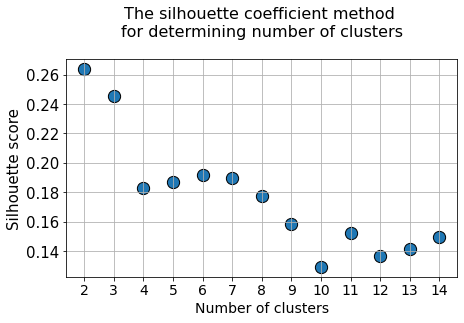

In [15]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,15)], y=km_silhouette, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [16]:
# Как видим коэфф. силуэта достигаем локальных максимумов при значениях кол-ва кластеров 6, 11 

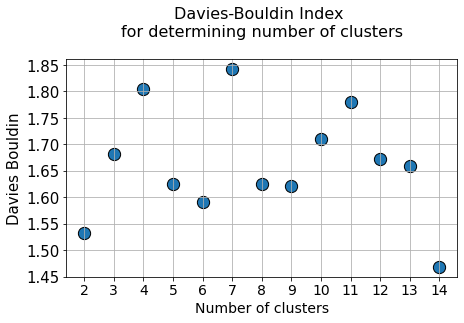

In [17]:
plt.figure(figsize=(7,4))
plt.title("Davies-Bouldin Index \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,15)], y=db_score, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Davies Bouldin",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [18]:
# Более низкое значение Davies-Bouldin Index соотвествует значениям кол-ва кластеров 9 и 14  

In [19]:
# Рассмотрим более подробно расчет на 8 кластеров:

km = KMeans(n_clusters=8, random_state=0).fit(res_sc)
preds = km.predict(res_sc)

In [20]:
preds

array([4, 1, 1, 4, 4, 4, 0, 0, 3, 4, 1, 0, 0, 0, 0, 3, 3, 0, 4, 4, 1, 0,
       1, 1, 3, 3, 3, 0, 0, 3, 3, 0, 4, 4, 4, 4, 1, 1, 3, 3, 3, 0, 1, 1,
       4, 4, 4, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 0,
       4, 1, 1, 1, 1, 7, 7, 7, 7, 3, 5, 1, 7, 7, 7, 7, 7, 7, 7, 2, 5, 2,
       2, 5, 5, 2, 5, 4, 4, 6, 6, 6, 6, 6, 6, 6])

In [21]:
km.labels_

array([4, 1, 1, 4, 4, 4, 0, 0, 3, 4, 1, 0, 0, 0, 0, 3, 3, 0, 4, 4, 1, 0,
       1, 1, 3, 3, 3, 0, 0, 3, 3, 0, 4, 4, 4, 4, 1, 1, 3, 3, 3, 0, 1, 1,
       4, 4, 4, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 0,
       4, 1, 1, 1, 1, 7, 7, 7, 7, 3, 5, 1, 7, 7, 7, 7, 7, 7, 7, 2, 5, 2,
       2, 5, 5, 2, 5, 4, 4, 6, 6, 6, 6, 6, 6, 6])

In [22]:
lab, lab_count = np.unique(km.labels_, return_counts = True)

In [23]:
lab, lab_count 

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([14, 27,  4, 17, 17,  5,  7, 11], dtype=int64))

<BarContainer object of 8 artists>

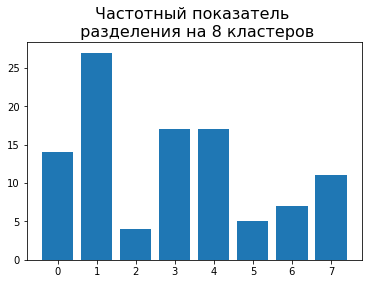

In [24]:
plt.title("Частотный показатель \n разделения на 8 кластеров",fontsize=16)
plt.bar(lab, lab_count)

In [25]:
len(km.labels_)

102

In [26]:
# 3.2. Mean-Shift кластеризация (автоматический расчет кластеров)

bandwidth = estimate_bandwidth(res_sc, random_state=0, quantile=0.2)

kms = MeanShift(bandwidth = bandwidth).fit(res_sc)
preds_kms = kms.predict(res_sc)

In [27]:
lab_s, lab_count_s = np.unique(kms.labels_, return_counts = True)

In [28]:
lab_s, lab_count_s

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([65,  1,  6, 19,  1,  6,  3,  1], dtype=int64))

In [29]:
lab_count_s

array([65,  1,  6, 19,  1,  6,  3,  1], dtype=int64)

<BarContainer object of 8 artists>

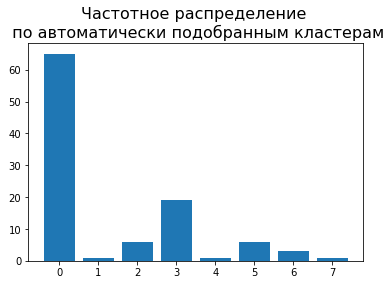

In [30]:
plt.title("Частотное распределение \n по автоматически подобранным кластерам",fontsize=16)
plt.bar(lab_s, lab_count_s)

In [31]:
# 3.3. Affinity propagation кластеризация (автоматический расчет кластеров)

aff = AffinityPropagation(random_state=0).fit(res_sc)
lab_a, lab_count_a = np.unique(aff.labels_, return_counts = True)

In [32]:
lab_a, lab_count_a

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 6, 13, 11, 16, 30, 10,  4,  5,  7], dtype=int64))

<BarContainer object of 9 artists>

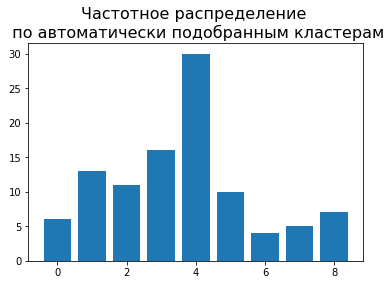

In [33]:
plt.title("Частотное распределение \n по автоматически подобранным кластерам",fontsize=16)
plt.bar(lab_a, lab_count_a)

In [34]:
# Подтверждение AffinityPropagation через визуальное отображение посредством TSNE алгоритма
X_embedded = TSNE(n_components=2, perplexity=5, learning_rate=10, n_iter=5000).fit_transform(res_sc)
X_embedded.shape

(102, 2)

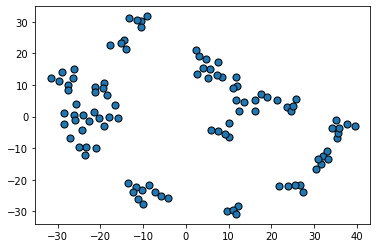

In [35]:
plt.scatter(X_embedded[:, 0],X_embedded[:, 1], s=50, edgecolor='k')

In [36]:
# Как видим, кол-во кластеров колеблется около 8-11

In [37]:
# 3.4. Agglomerative кластеризация
#количество кластеров будем пытаться определить методом Silhouette Coefficient

agc = AgglomerativeClustering().fit(res_sc)
lab_ag, lab_count_ag = np.unique(agc.labels_, return_counts = True)


In [38]:
lab_ag, lab_count_ag

(array([0, 1], dtype=int64), array([49, 53], dtype=int64))

In [39]:
km_silhouette = []

for i in range(2,15):
    agc = AgglomerativeClustering(n_clusters=i).fit_predict(res_sc)
    
    silhouette = silhouette_score(res_sc, agc)
    km_silhouette.append(silhouette)
    print(f"Silhouette score for number of cluster(s) {i}: {silhouette}")
    

Silhouette score for number of cluster(s) 2: 0.2500203450606257
Silhouette score for number of cluster(s) 3: 0.24642910173137597
Silhouette score for number of cluster(s) 4: 0.1734939345900983
Silhouette score for number of cluster(s) 5: 0.15309351458898687
Silhouette score for number of cluster(s) 6: 0.14985654529308076
Silhouette score for number of cluster(s) 7: 0.16280375231717784
Silhouette score for number of cluster(s) 8: 0.16836583718020692
Silhouette score for number of cluster(s) 9: 0.17205075334866626
Silhouette score for number of cluster(s) 10: 0.17852236600658578
Silhouette score for number of cluster(s) 11: 0.17567127270347277
Silhouette score for number of cluster(s) 12: 0.16787064390135067
Silhouette score for number of cluster(s) 13: 0.1431275977126957
Silhouette score for number of cluster(s) 14: 0.14608130371065484


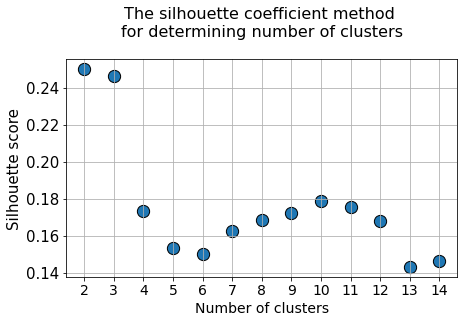

In [40]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,15)], y=km_silhouette, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,15)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [41]:
# Как видим коэфф. силуэта достигает локальных максимумов при значениях кол-ва кластеров 10

In [42]:
agc = AgglomerativeClustering(n_clusters=10).fit(res_sc)
lab_ag, lab_count_ag = np.unique(agc.labels_, return_counts = True)


<BarContainer object of 10 artists>

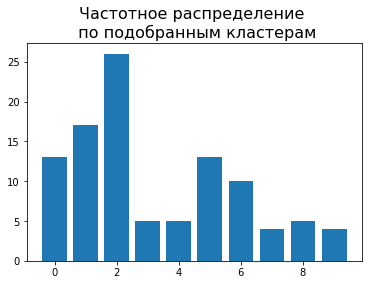

In [43]:
plt.title("Частотное распределение \n по подобранным кластерам",fontsize=16)
plt.bar(lab_ag, lab_count_ag)

#### СКЛОНЯЮСЬ К ВЫБОРУ АЛГОРИТМА AffinityPropagation, Т.К. КАК МНЕ КАЖЕТСЯ, ДАННЫЙ АЛГОРИТМ НАИБОЛЕЕ АДЕКВАТНО РАССЧИТЫВАЕТ КОЛ-ВО КЛАСТЕРОВ И ДЕЛАЕТ НАИБОЛЕЕ РАЗУМНОЕ ЧАСТОТНОЕ РАСПРЕДЕЛЕНИЕ РЕГИОНОВ ПО КЛАСТЕРАМ

In [44]:
# Построение графиков стандартизованных рядов каждого кластера.

In [45]:
res_sc.head(20)

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1075               0.222679             1.016254             0.391013   
1076               0.100211             0.755825             0.255174   
1077              -0.108691            -0.214710            -0.184419   
1125               0.498090             1.220335             1.430019   
1126               0.793513             1.739180             1.369920   
1127               1.272384             1.469364             0.884219   
1128               1.113618             0.748738             0.518287   
1129               1.515722             0.901776             0.363522   
1130               1.670000             0.623150             0.020418   
1131               1.189513             0.667852            -0.042495   
1132              -0.335603            -0.209770            -0.587268   
1172               1.775312             6.196132             6.490853   
1173               1.475444             3.290779             4.092904   
1174               1.678731             4.253838             4.127193   
1175               1.890651             2.698394             2.159899   
1176               0.909117             1.709311             2.727741   
1177               1.208582             1.066457             0.789495   
1178               0.777404             0.419990             0.114956   
1179               1.232654             0.315163             0.011557   
1180               1.353080             0.268268            -0.125091   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1075               0.318870            -0.739230            -1.268280   
1076              -0.221636            -0.615004            -1.294459   
1077              -1.078009            -1.138592            -1.184029   
1125               0.754370            -0.340647            -1.272576   
1126               0.721463            -0.251223            -0.944712   
1127               0.947947             0.078920            -0.894391   
1128               0.412664             0.071789            -0.638767   
1129               0.245779            -0.275655            -0.797089   
1130              -0.497720            -0.437799            -0.705680   
1131              -0.641851            -0.752843            -1.185711   
1132              -0.533340            -0.820957            -0.874886   
1172               4.722525             2.512115             0.743787   
1173               3.501865             1.770964             0.631102   
1174               2.354169             0.370069            -0.305369   
1175               0.993159             0.903410            -0.442829   
1176               6.074008             4.619109             0.472648   
1177               1.055524             0.971707             0.111666   
1178              -0.054507            -0.100724            -0.565978   
1179              -0.141914            -0.375457            -0.929287   
1180              -0.238797            -0.539963            -1.096198   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1075              -1.220184            -1.172089            -1.148041   
1076              -1.282539            -1.234858            -1.175257   
1077              -1.350630            -1.290048            -1.244611   
1125              -1.412366            -1.389067            -1.365769   
1126              -1.142852            -1.214903            -1.322979   
1127              -1.149305            -1.438981            -1.427394   
1128              -0.994046            -1.258104            -1.459748   
1129              -1.158728            -1.238625            -1.352163   
1130              -0.931263            -1.012333            -1.3

In [46]:
aff.cluster_centers_

array([[ 1.67873055,  4.25383787,  4.12719325, ...,  0.58114383,
         0.03235046,  0.41228433],
       [ 1.35307968,  0.26826801, -0.12509146, ...,  0.95972021,
         0.72001678,  1.0764988 ],
       [ 2.30591093,  2.39690296,  2.00260418, ...,  0.65288916,
         1.320164  ,  1.90782083],
       ...,
       [ 1.20229408,  2.89900646,  2.89900646, ..., -0.65600996,
        -0.65600996, -0.57521413],
       [ 2.39008138,  9.68836881,  9.52436235, ..., -0.39802842,
        -0.31602519,  0.42200387],
       [-1.10465293, -1.24842381, -1.41016604, ...,  0.87219658,
         0.92611066,  0.96205338]])

In [47]:
aff.cluster_centers_indices_

array([13, 19, 31, 51, 55, 71, 88, 90, 97], dtype=int64)

In [48]:
# формирование словаря центров кластеров
dicts = {}
keys = range(9)

for i in keys:
        dicts[i] = res_sc.index[aff.cluster_centers_indices_[i]]
print(dicts) 

{0: 1174, 1: 1180, 2: 1229, 3: 1326, 4: 1333, 5: 1387, 6: 1530, 7: 1533, 8: 2068}


In [49]:
aff.labels_

array([1, 4, 4, 1, 1, 1, 2, 2, 3, 1, 4, 0, 0, 0, 0, 2, 3, 2, 1, 1, 4, 2,
       4, 4, 3, 3, 3, 2, 0, 3, 3, 2, 2, 1, 1, 1, 4, 4, 3, 3, 3, 2, 4, 4,
       1, 1, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3, 2,
       1, 4, 4, 4, 4, 5, 5, 5, 5, 3, 7, 4, 5, 5, 5, 5, 5, 5, 0, 6, 7, 6,
       6, 7, 7, 6, 7, 4, 4, 8, 8, 8, 8, 8, 8, 8], dtype=int64)

In [50]:
lab_a, lab_count_a

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 6, 13, 11, 16, 30, 10,  4,  5,  7], dtype=int64))

In [51]:
res_sc_mean = res_sc.rolling(500, axis=1).mean()
res_sc_mean['cluster'] =aff.labels_

In [52]:
res_sc_mean

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1075                    NaN                  NaN                  NaN   
1076                    NaN                  NaN                  NaN   
1077                    NaN                  NaN                  NaN   
1125                    NaN                  NaN                  NaN   
1126                    NaN                  NaN                  NaN   
...                     ...                  ...                  ...   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1075                    NaN                  NaN                  NaN   
1076                    NaN                  NaN                  NaN   
1077                    NaN                  NaN                  NaN   
1125                    NaN                  NaN                  NaN   
1126                    NaN                  NaN                  NaN   
...                     ...                  ...                  ...   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1075                    NaN                  NaN                  NaN   
1076                    NaN                  NaN                  NaN   
1077                    NaN                  NaN                  NaN   
1125                    NaN                  NaN                  NaN   
1126                    NaN                  NaN                  NaN   
...                     ...                  ...                  ...   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 09:00:00  ...  2016-04-30 15:00:00  2016-04-30 16:00:00  \
region                       ...                                             
1075                    NaN  ...             0.028855             0.031452   
1076                    NaN  ...             0.000510             0.000748   
1077                    NaN  ...            -0.026723            -0.025511   
1125                    NaN  ...            -0.114001            -0.114933   
1126                    NaN  ...            -0.139346            -0.140589   
...                     ...  ...                  ...                  ...   
2068                    NaN  ...             0.166785             0.166713   
2069                    NaN  ...             0.141177             0.143159   
2118                    NaN  ...             0.122287             0.123282   
2119                    NaN  ...            -0.346281            -0.347083   
2168                    NaN  ...             0.200123             0.198123   

        2016-04-30 17:00:00  2016-04-30 18:00:00  2016-04-30 19:00:00  \
region                                                                

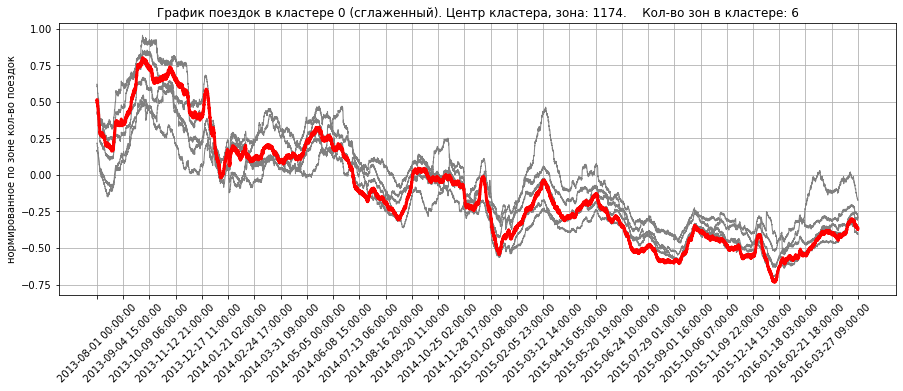

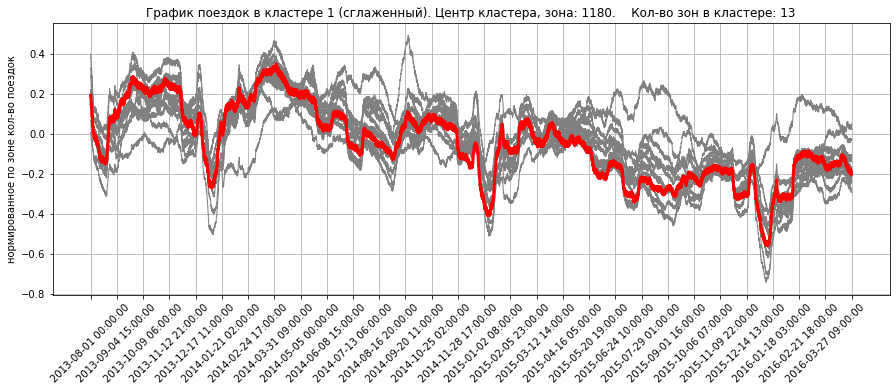

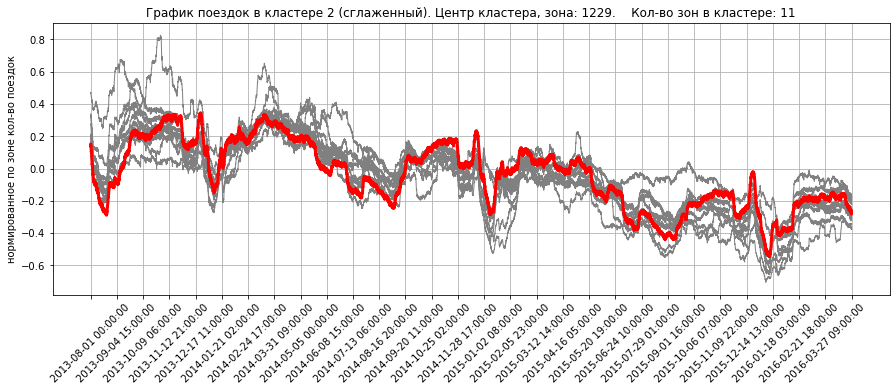

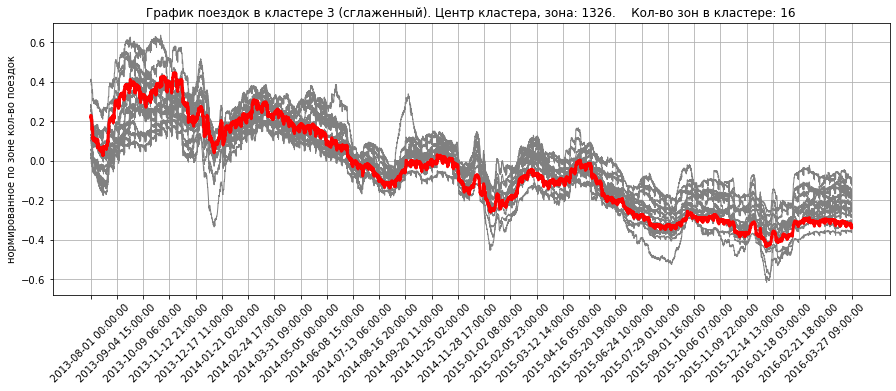

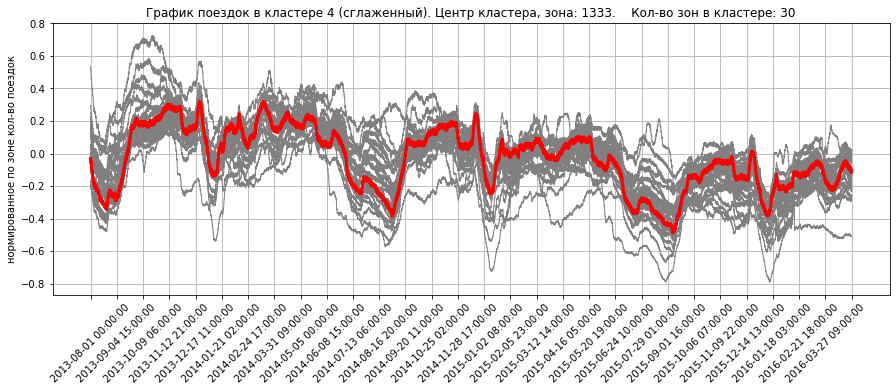

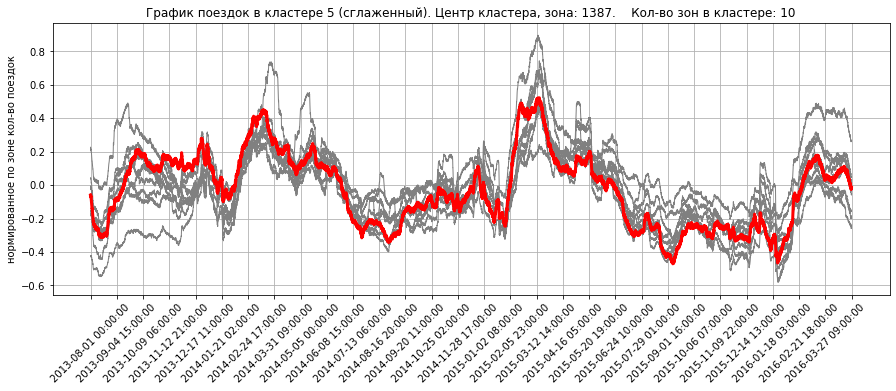

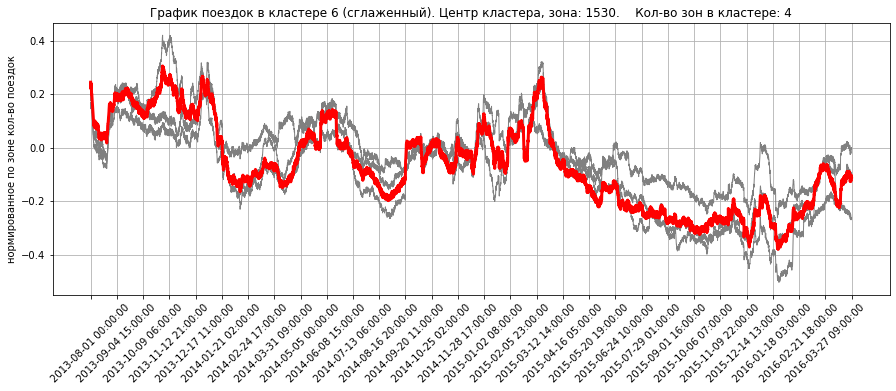

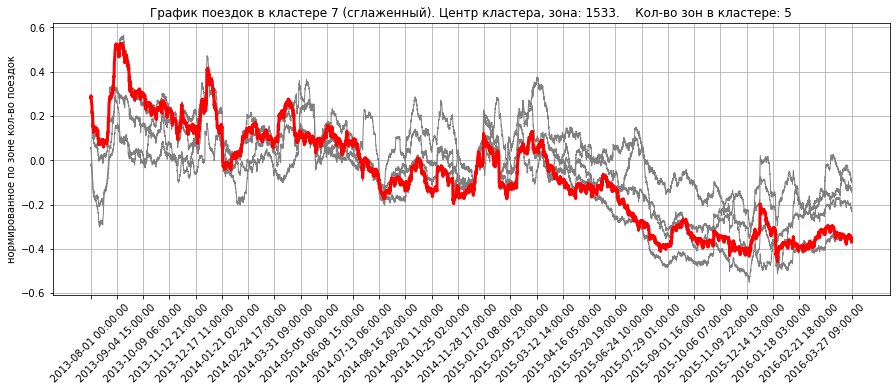

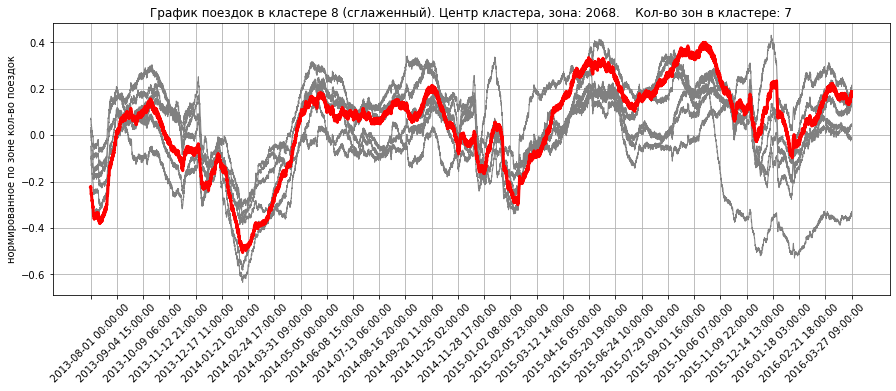

In [53]:
# multiple line plot
for c in range(len(lab_a)):
    res_sc_mean_claster = res_sc_mean[res_sc_mean['cluster'] == c].drop(['cluster'], axis=1)
    plt.figure(figsize=(15,5))

    for i in res_sc_mean_claster.index:
        plt.plot(res_sc_mean_claster.loc[i, '2013-08-01 00:00:00':'2016-04-31 23:00:00'] , color='grey', linewidth=1, alpha=1)
        
    plt.plot(res_sc_mean_claster.loc[dicts[c], '2013-08-01 00:00:00':'2016-04-31 23:00:00'], linewidth=3, color='r')
    
    plt.title(f'График поездок в кластере {c} (сглаженный). Центр кластера, зона: {dicts[c]}.\
    Кол-во зон в кластере: {len(res_sc_mean_claster.index)}')
    plt.xticks(np.linspace(0, 24095, num=30, endpoint=True), rotation=45)
    plt.ylabel('нормированное по зоне кол-во поездок')

    plt.grid(True)
    plt.show()

In [54]:
res_sc_mean_claster = res_sc_mean[res_sc_mean['cluster'] == c].drop(['cluster'], axis=1)

In [55]:
res_sc_mean_claster

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1734                    NaN                  NaN                  NaN   
1783                    NaN                  NaN                  NaN   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1734                    NaN                  NaN                  NaN   
1783                    NaN                  NaN                  NaN   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1734                    NaN                  NaN                  NaN   
1783                    NaN                  NaN                  NaN   
2068                    NaN                  NaN                  NaN   
2069                    NaN                  NaN                  NaN   
2118                    NaN                  NaN                  NaN   
2119                    NaN                  NaN                  NaN   
2168                    NaN                  NaN                  NaN   

        2013-01-01 09:00:00  ...  2016-04-30 14:00:00  2016-04-30 15:00:00  \
region                       ...                                             
1734                    NaN  ...            -0.018600            -0.017458   
1783                    NaN  ...             0.039231             0.041497   
2068                    NaN  ...             0.165742             0.166785   
2069                    NaN  ...             0.141920             0.141177   
2118                    NaN  ...             0.121560             0.122287   
2119                    NaN  ...            -0.348687            -0.346281   
2168                    NaN  ...             0.201437             0.200123   

        2016-04-30 16:00:00  2016-04-30 17:00:00  2016-04-30 18:00:00  \
region                                                                  
1734              -0.016456            -0.016289            -0.016417   
1783               0.042267             0.044381             0.045439   
2068               0.166713             0.169409             0.170092   
2069               0.143159             0.145389             0.141920   
2118               0.123282             0.126646             0.126080   
2119              -0.347083            -0.344122            -0.344122   
2168               0.198123             0.196751             0.195208   

        2016-04-30 19:00:00  2016-04-30 20:00:00  2016-04-30 21:00:00  \
region                                                                  
1734              -0.017098            -0.016302            -0.013913   
1783               0.045273             0.045756             0.046768   
2068               0.171817             0.174980             0.179509   
2069               0.142168             0.142911             0.146380   
2118               0.125677             0.129659             0.133507   
2119              -0.342703            -0.339680            -0.334683   
2168               0.197380             0.201380             0.207324   

        2016-04

#### 5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

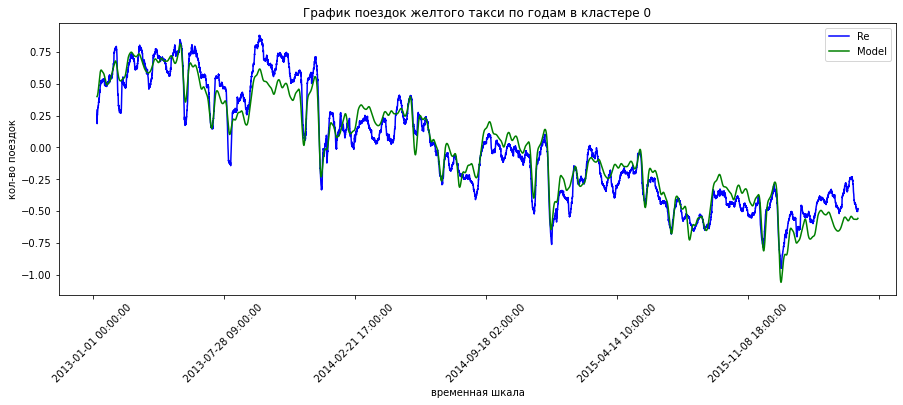

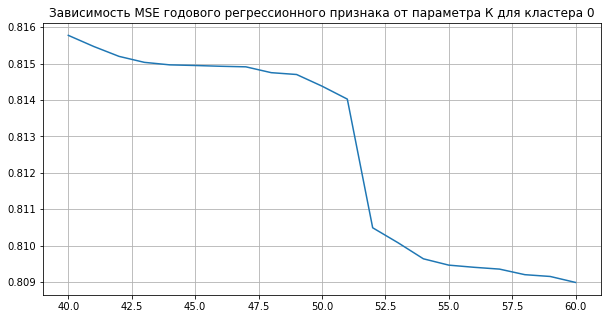

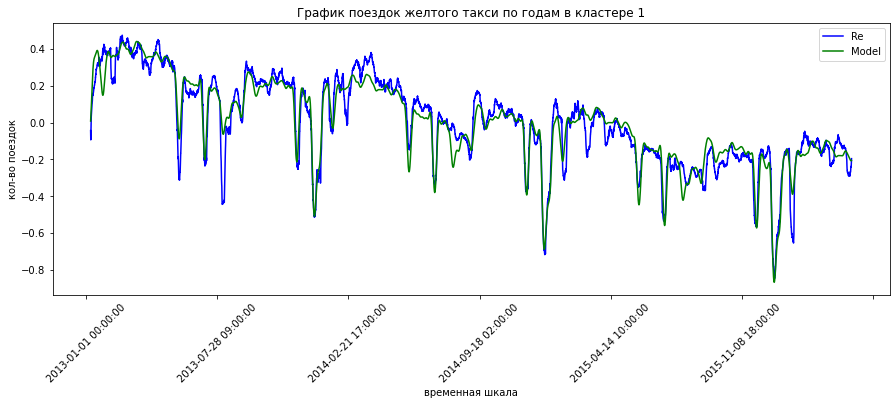

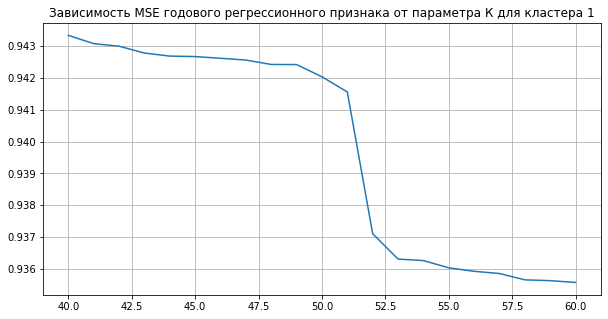

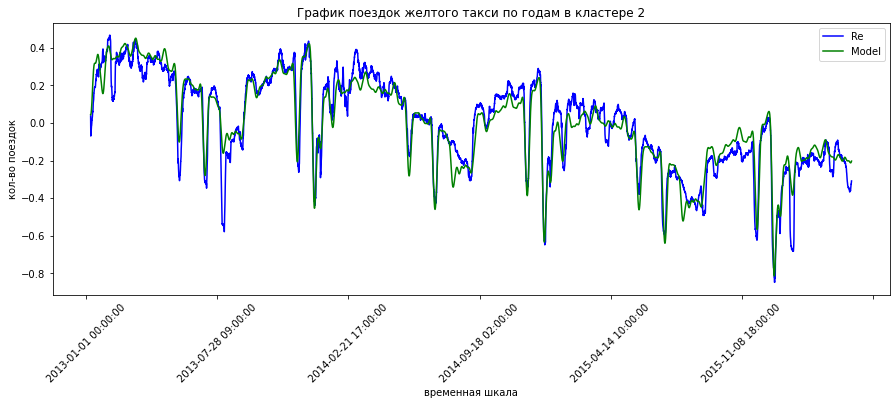

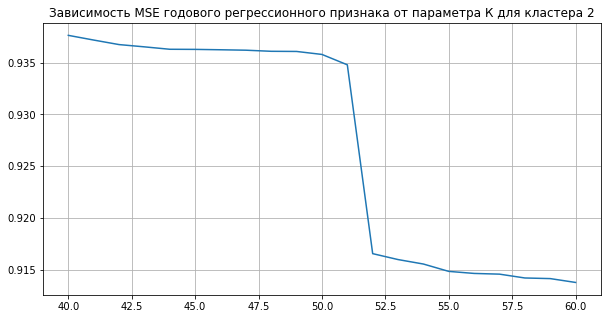

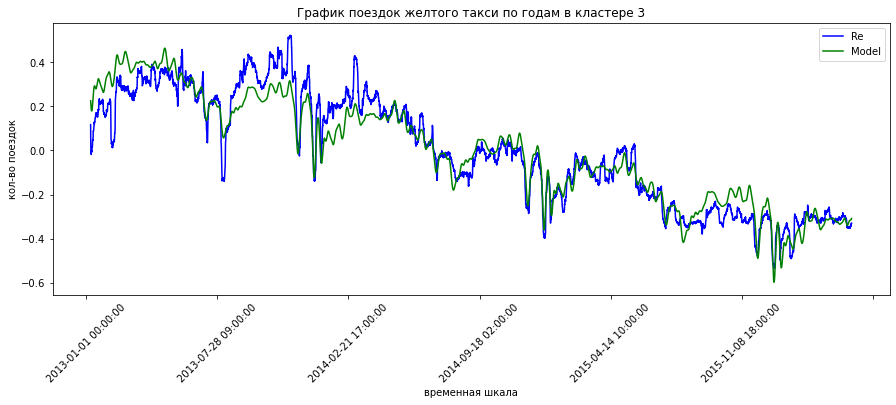

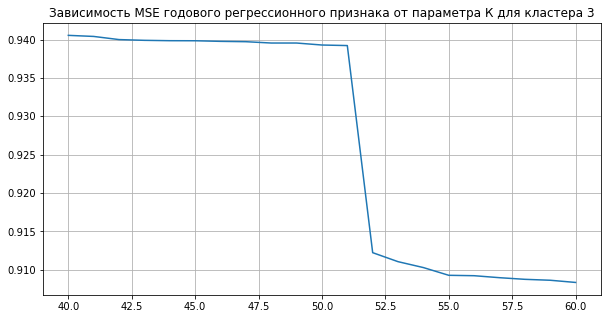

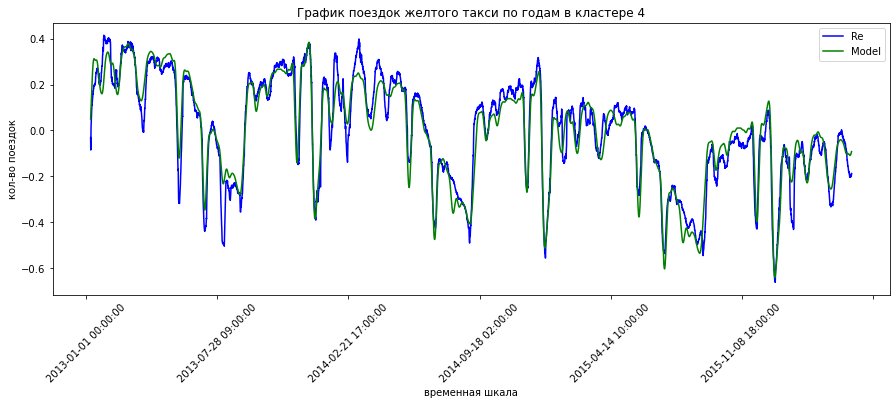

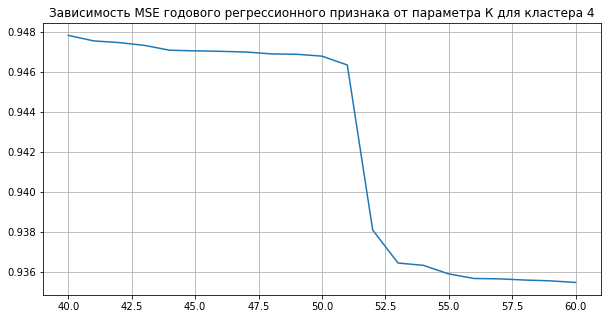

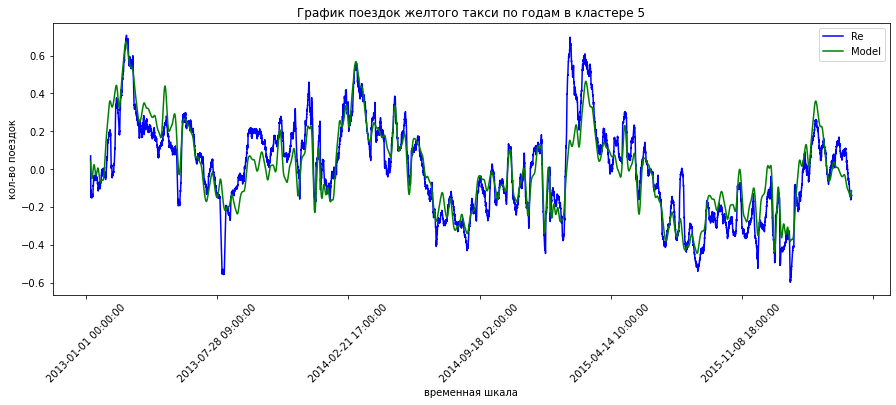

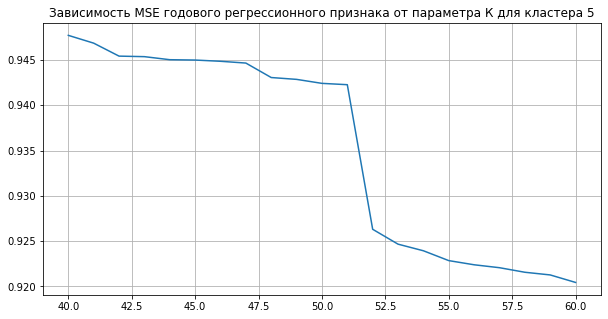

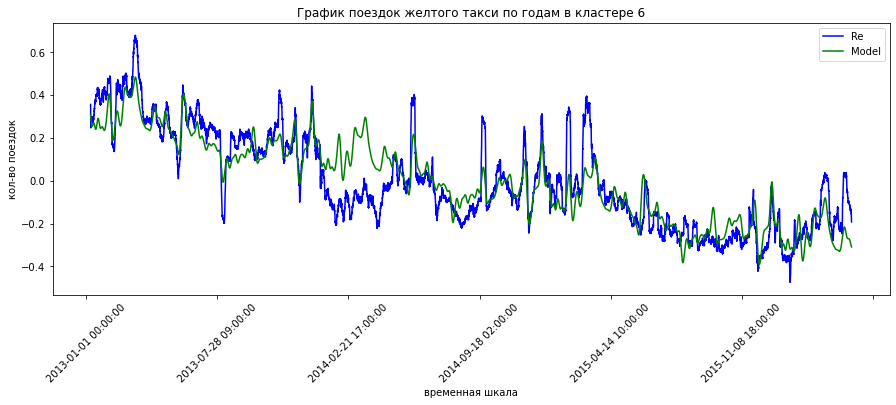

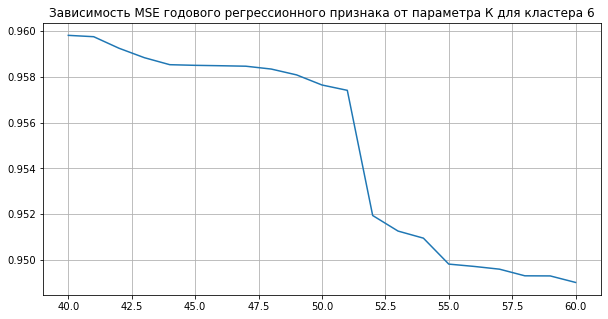

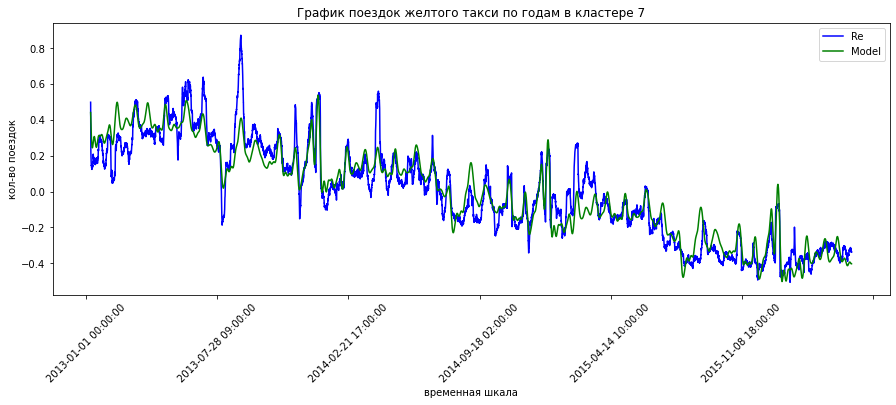

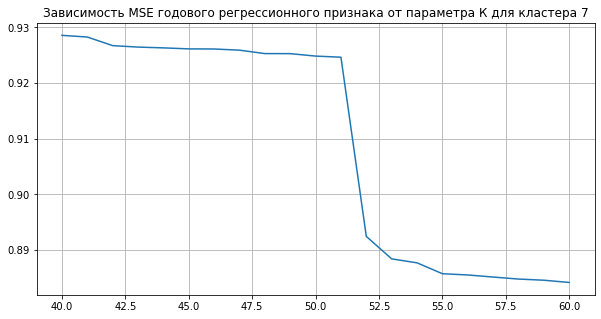

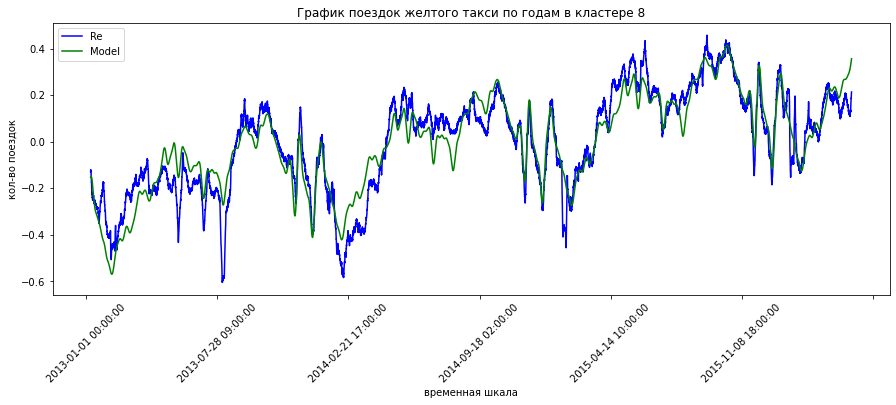

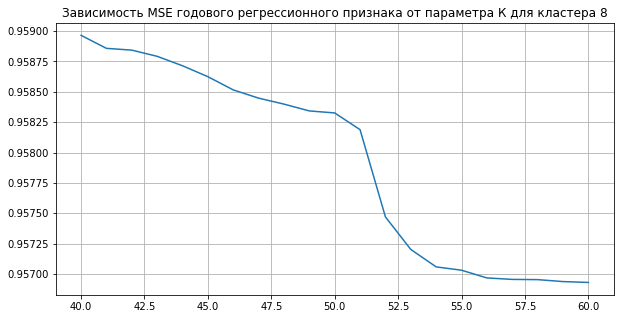

In [56]:
# создание регрессионного признака для годовой сезонности с использованием СТАНДАРТСКАЛЕР:
dicts_predict = pd.DataFrame(index = res_sc.columns)

for cl in range(len(lab_a)):

    mse_list = []
    N = 40 
    K =60
    for number in range(N, K+1):
        s_c_reg = pd.DataFrame(res_sc.loc[dicts[cl], :])
        length = res_sc.loc[dicts[cl], :].shape[0]
        for i in range(1, number+1):
            s_c_reg['s_0'] = np.arange(1, length+1)
            s_c_reg['s_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/8766)
            s_c_reg['c_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/8766)
        y = res_sc.loc[dicts[cl], :]
        X = s_c_reg.loc[:, 's_0':]
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
        K_opt = np.argmin(mse_list)
    
    dicts_predict[dicts[cl]] = res.predict(X)
    
    # график количества поездок жёлтого такси
    plt.figure(figsize=(15, 5))

    res_sc.loc[dicts[cl]].rolling(168).mean().plot(color='b', label='Re')
    dicts_predict[dicts[cl]].rolling(168).mean().plot(color='g', label='Model')
    plt.legend()

    plt.title(f'График поездок желтого такси по годам в кластере {cl}')
    plt.xlabel('временная шкала')
    plt.xticks(rotation=45)
    plt.ylabel('кол-во поездок')
    plt.show()
    
    # график зависимости MSE годового регрессионного признака от параметра К
    plt.figure(figsize=(10, 5))
    plt.plot(range(N, K+1), mse_list)
    plt.grid(True)
    plt.title(f'Зависимость MSE годового регрессионного признака от параметра К для кластера {cl}')
    plt.show()

Как видим из графика и табличных значений (приведены на 3ей неделе), MSE резко падает в районе K=52 для всех центров кластеров\
Для годовой сезонности значение параметра К возьмем равным 53

In [57]:
# Начало обьединения признаков:
reg_all = X.loc[:, :'c_53']

In [58]:
reg_all

s_0       s_1       c_1       s_2       c_2       s_3  \
2013-01-01 00:00:00      1  0.000717  1.000000  0.001434  0.999999  0.002150   
2013-01-01 01:00:00      2  0.001434  0.999999  0.002867  0.999996  0.004301   
2013-01-01 02:00:00      3  0.002150  0.999998  0.004301  0.999991  0.006451   
2013-01-01 03:00:00      4  0.002867  0.999996  0.005734  0.999984  0.008601   
2013-01-01 04:00:00      5  0.003584  0.999994  0.007168  0.999974  0.010751   
...                    ...       ...       ...       ...       ...       ...   
2016-04-30 19:00:00  29178  0.880683 -0.473706 -0.834370 -0.551205 -0.090190   
2016-04-30 20:00:00  29179  0.880343 -0.474337 -0.835159 -0.550008 -0.088048   
2016-04-30 21:00:00  29180  0.880003 -0.474968 -0.835947 -0.548810 -0.085906   
2016-04-30 22:00:00  29181  0.879662 -0.475599 -0.836733 -0.547611 -0.083764   
2016-04-30 23:00:00  29182  0.879321 -0.476229 -0.837517 -0.546411 -0.081621   

                          c_3       s_4       c_4       s_5  ...      s_49  \
2013-01-01 00:00:00  0.999998  0.002867  0.999996  0.003584  ...  0.035114   
2013-01-01 01:00:00  0.999991  0.005734  0.999984  0.007168  ...  0.070185   
2013-01-01 02:00:00  0.999979  0.008601  0.999963  0.010751  ...  0.105170   
2013-01-01 03:00:00  0.999963  0.011468  0.999934  0.014335  ...  0.140025   
2013-01-01 04:00:00  0.999942  0.014335  0.999897  0.017918  ...  0.174707   
...                       ...       ...       ...       ...  ...       ...   
2016-04-30 19:00:00  0.995925  0.919817 -0.392347 -0.781257  ...  0.580455   
2016-04-30 20:00:00  0.996116  0.918689 -0.394983 -0.783489  ...  0.608690   
2016-04-30 21:00:00  0.996303  0.917552 -0.397615 -0.785711  ...  0.636175   
2016-04-30 22:00:00  0.996486  0.916409 -0.400244 -0.787922  ...  0.662875   
2016-04-30 23:00:00  0.996663  0.915257 -0.402870 -0.790124  ...  0.688757   

                         c_49      s_50      c_50      s_51      c_51  \
2013-01-01 00:00:00  0.999383  0.035831  0.999358  0.036547  0.999332   
2013-01-01 01:00:00  0.997534  0.071615  0.997432  0.073045  0.997329   
2013-01-01 02:00:00  0.994454  0.107308  0.994226  0.109446  0.993993   
2013-01-01 03:00:00  0.990148  0.142863  0.989742  0.145700  0.989329   
2013-01-01 04:00:00  0.984620  0.178234  0.983988  0.181760  0.983343   
...                       ...       ...       ...       ...       ...   
2016-04-30 19:00:00  0.814292  0.442168 -0.896932 -0.999371  0.035473   
2016-04-30 20:00:00  0.793408  0.409747 -0.912199 -0.997407  0.071973   
2016-04-30 21:00:00  0.771545  0.376799 -0.926295 -0.994110  0.108377   
2016-04-30 22:00:00  0.748730  0.343367 -0.939201 -0.989485  0.144636   
2016-04-30 23:00:00  0.724992  0.309494 -0.950901 -0.983538  0.180702   

                         s_52      c_52      s_53      c_53  
2013-01-01 00:00:00  0.037263  0.999305  0.037980  0.999279  
2013-01-01 01:00:00  0.074475  0.997223  0.075904  0.997115  
2013-01-01 02:00:00  0.111583  0.993755  0.113720  0.993513  
2013-01-01 03:00:00  0.148536  0.988907  0.151371  0.988477  
2013-01-01 04:00:00  0.185283  0.982685  0.188803  0.982015  
...                       ...       ...       ...       ...  
2016-04-30 19:00:00  0.504648  0.863325  0.521260 -0.853398  
2016-04-30 20:00:00  0.536468  0.843921  0.488473 -0.872579  
2016-04-30 21:00:00  0.567543  0.823344  0.454980 -0.890502  
2016-04-30 22:00:00  0.597829  0.801624  0.420831 -0.907139  
2016-04-30 23:00:00  0.627285  0.778790  0.386075 -0.922468  

[29182 rows x 107 columns]

In [59]:
# создание регрессионного признака для недельной сезонности:

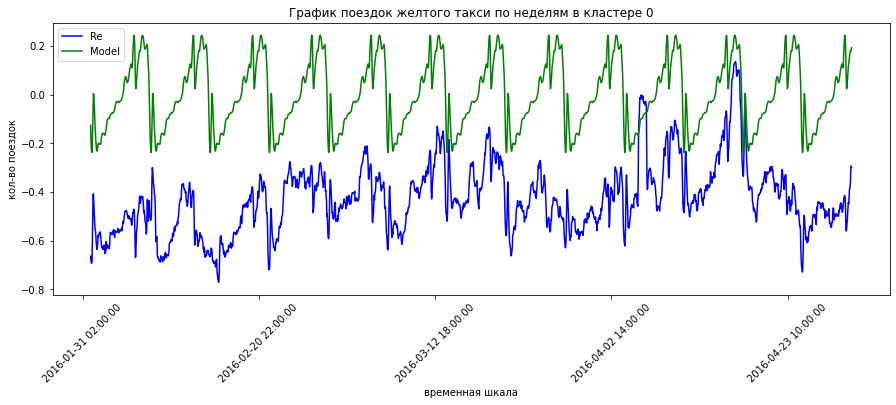

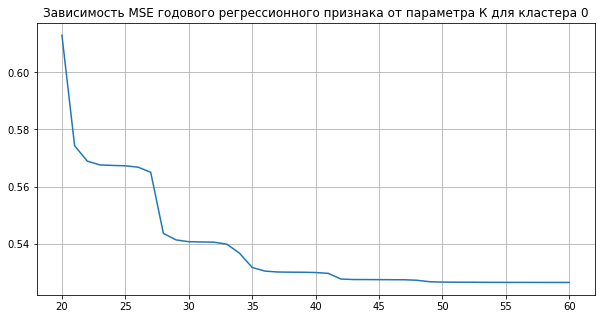

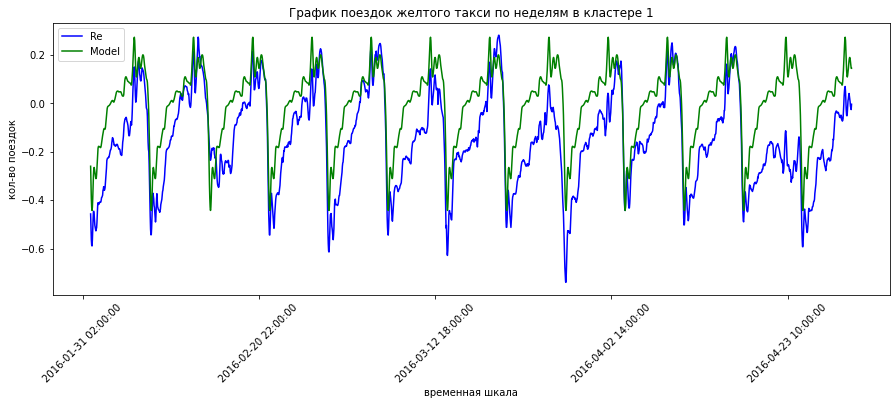

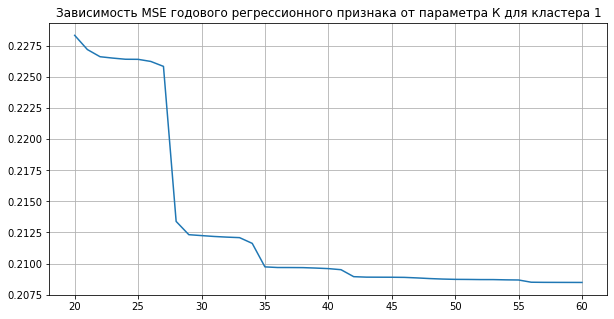

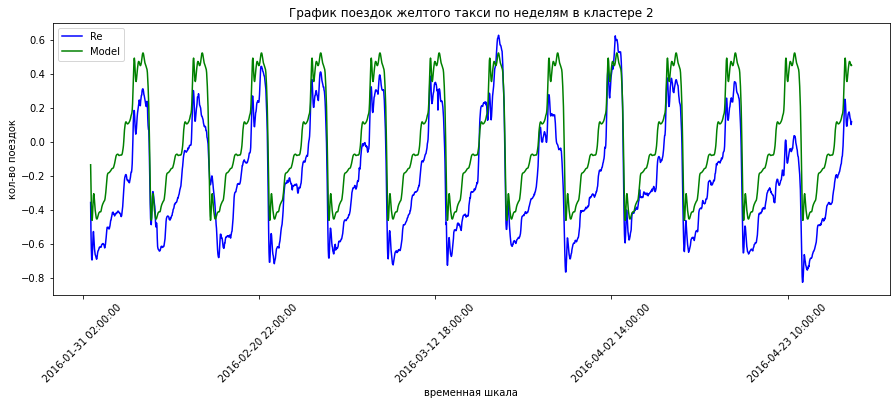

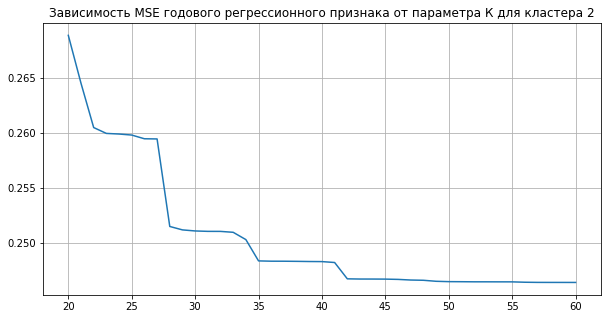

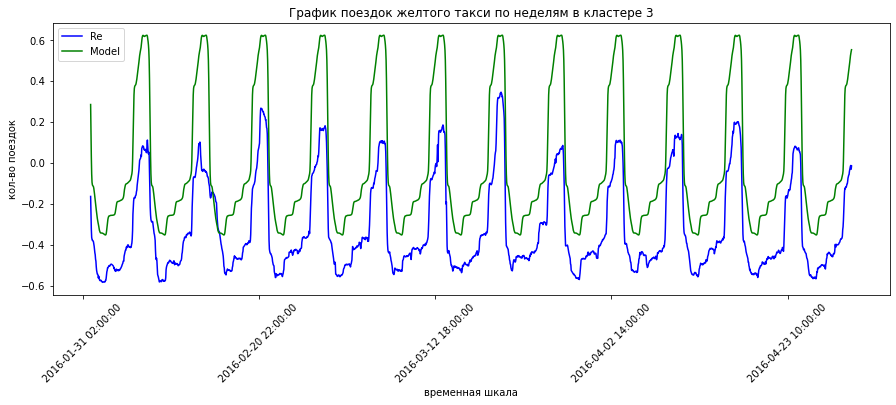

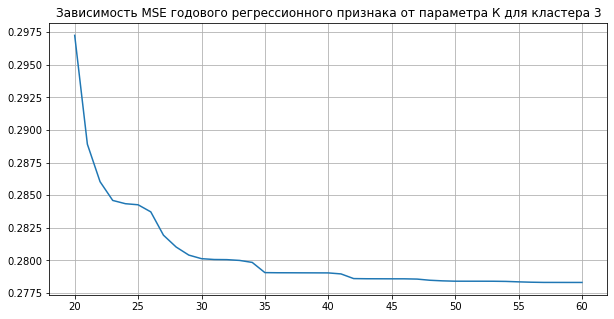

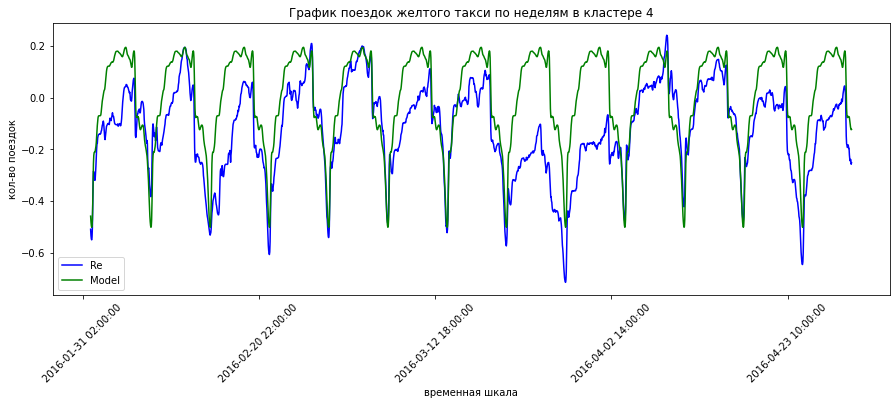

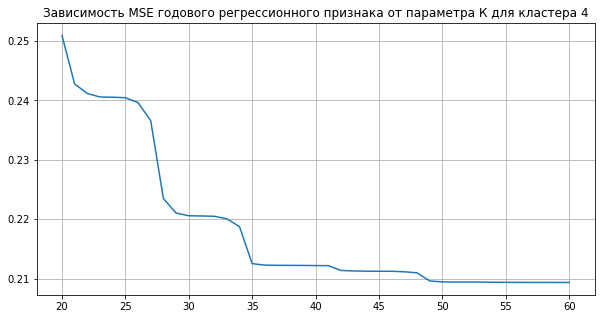

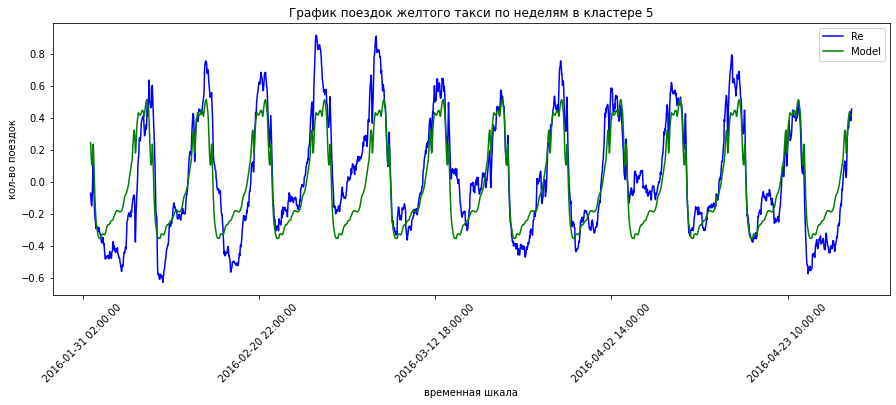

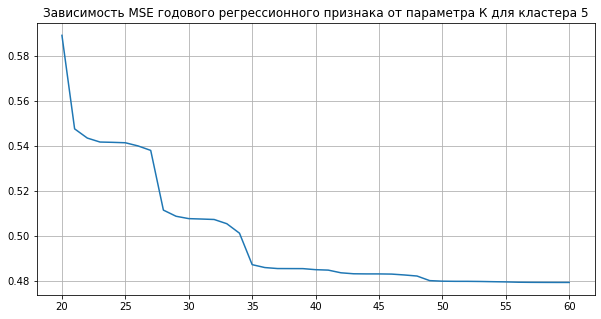

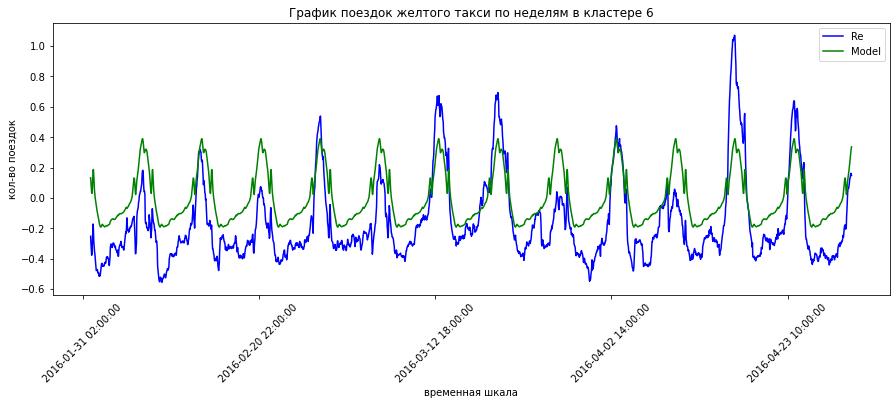

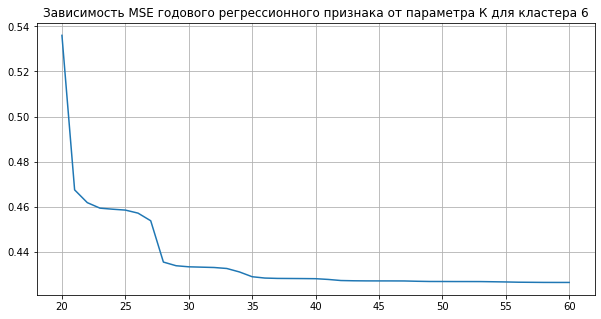

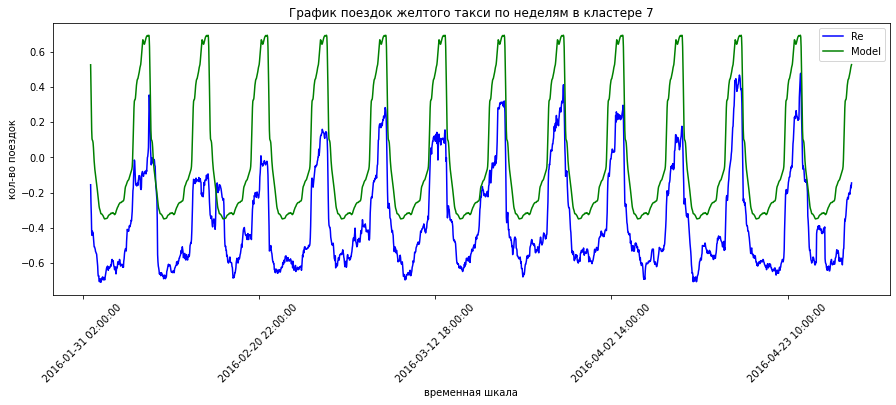

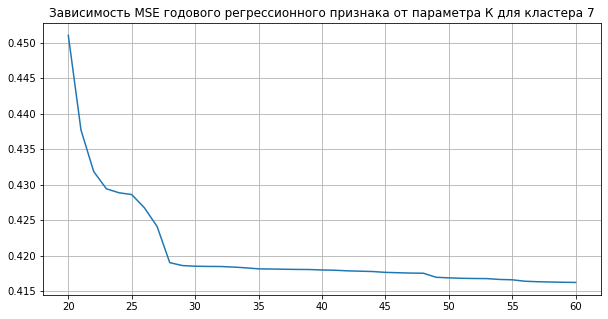

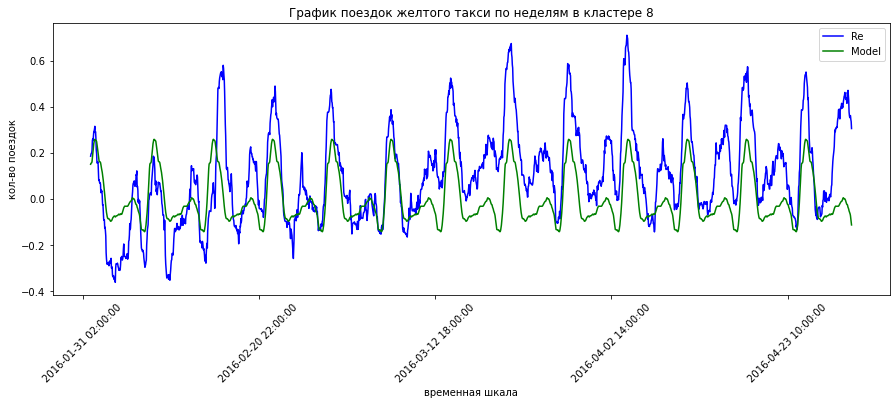

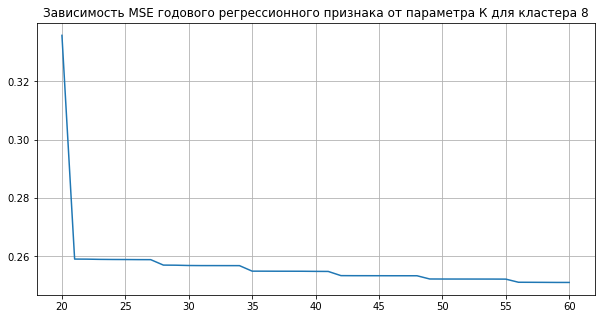

In [60]:
# создание регрессионного признака для недельной сезонности  с использованием СТАНДАРТСКАЛЕР:
for cl in range(len(lab_a)):
    mse_list = []
    N = 20 
    K = 60
    for number in range(N, K+1):
        s_c_reg = pd.DataFrame(res_sc.loc[dicts[cl], :])  # пока проверка на  cl  кластер
        length = res_sc.loc[dicts[cl], :].shape[0]
        for i in range(1, number+1):
            s_c_reg['ss_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/168)
            s_c_reg['cc_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/168)
        y = res_sc.loc[dicts[cl], :]
        X = s_c_reg.loc[:, 'ss_1':]
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
        K_opt = np.argmin(mse_list)
    
    dicts_predict[dicts[cl]] = res.predict(X)

    # график количества поездок жёлтого такси из ячейки с кластером cl.
    plt.figure(figsize=(15, 5))

    res_sc.loc[dicts[cl]][27000:].rolling(24).mean().plot(color='b', label='Re')
    dicts_predict[dicts[cl]][27000:].rolling(24).mean().plot(color='g', label='Model')
    plt.legend()

    plt.title(f'График поездок желтого такси по неделям в кластере {cl}')
    plt.xlabel('временная шкала')
    plt.xticks(rotation=45)
    plt.ylabel('кол-во поездок')
    plt.show()
    
    # график зависимости MSE годового регрессионного признака от параметра К
    plt.figure(figsize=(10, 5))
    plt.plot(range(N, K+1), mse_list)
    plt.grid(True)
    plt.title(f'Зависимость MSE годового регрессионного признака от параметра К для кластера {cl}')
    plt.show()

Как видим из графика и табличных значений, MSE резко падает в районе K=35\
Для недельной сезонности значение параметра К возьмем равным 36

In [61]:
# Обьединенные регрессионные признаки по недели и году:
frames1 =[reg_all, X.loc[:, :'cc_36']]
reg_all = pd.concat(frames1, axis=1)

In [62]:
# reg_all.to_csv('reg_all.csv') # запись регрессионных признаков для 5ой недели

In [63]:
reg_all

s_0       s_1       c_1       s_2       c_2       s_3  \
2013-01-01 00:00:00      1  0.000717  1.000000  0.001434  0.999999  0.002150   
2013-01-01 01:00:00      2  0.001434  0.999999  0.002867  0.999996  0.004301   
2013-01-01 02:00:00      3  0.002150  0.999998  0.004301  0.999991  0.006451   
2013-01-01 03:00:00      4  0.002867  0.999996  0.005734  0.999984  0.008601   
2013-01-01 04:00:00      5  0.003584  0.999994  0.007168  0.999974  0.010751   
...                    ...       ...       ...       ...       ...       ...   
2016-04-30 19:00:00  29178  0.880683 -0.473706 -0.834370 -0.551205 -0.090190   
2016-04-30 20:00:00  29179  0.880343 -0.474337 -0.835159 -0.550008 -0.088048   
2016-04-30 21:00:00  29180  0.880003 -0.474968 -0.835947 -0.548810 -0.085906   
2016-04-30 22:00:00  29181  0.879662 -0.475599 -0.836733 -0.547611 -0.083764   
2016-04-30 23:00:00  29182  0.879321 -0.476229 -0.837517 -0.546411 -0.081621   

                          c_3       s_4       c_4       s_5  ...     ss_32  \
2013-01-01 00:00:00  0.999998  0.002867  0.999996  0.003584  ...  0.930874   
2013-01-01 01:00:00  0.999991  0.005734  0.999984  0.007168  ...  0.680173   
2013-01-01 02:00:00  0.999979  0.008601  0.999963  0.010751  ... -0.433884   
2013-01-01 03:00:00  0.999963  0.011468  0.999934  0.014335  ... -0.997204   
2013-01-01 04:00:00  0.999942  0.014335  0.999897  0.017918  ... -0.294755   
...                       ...       ...       ...       ...  ...       ...   
2016-04-30 19:00:00  0.995925  0.919817 -0.392347 -0.781257  ... -0.974928   
2016-04-30 20:00:00  0.996116  0.918689 -0.394983 -0.783489  ... -0.563320   
2016-04-30 21:00:00  0.996303  0.917552 -0.397615 -0.785711  ...  0.563320   
2016-04-30 22:00:00  0.996486  0.916409 -0.400244 -0.787922  ...  0.974928   
2016-04-30 23:00:00  0.996663  0.915257 -0.402870 -0.790124  ...  0.149042   

                        cc_32     ss_33     cc_33     ss_34     cc_34  \
2013-01-01 00:00:00  0.365341  0.943883  0.330279  0.955573  0.294755   
2013-01-01 01:00:00 -0.733052  0.623490 -0.781831  0.563320 -0.826239   
2013-01-01 02:00:00 -0.900969 -0.532032 -0.846724 -0.623490 -0.781831   
2013-01-01 03:00:00  0.074730 -0.974928  0.222521 -0.930874  0.365341   
2013-01-01 04:00:00  0.955573 -0.111964  0.993712  0.074730  0.997204   
...                       ...       ...       ...       ...       ...   
2016-04-30 19:00:00 -0.222521  0.623490 -0.781831  0.433884  0.900969   
2016-04-30 20:00:00  0.826239 -0.532032 -0.846724  0.988831 -0.149042   
2016-04-30 21:00:00  0.826239 -0.974928  0.222521  0.149042 -0.988831   
2016-04-30 22:00:00 -0.222521 -0.111964  0.993712 -0.900969 -0.433884   
2016-04-30 23:00:00 -0.988831  0.900969  0.433884 -0.680173  0.733052   

                        ss_35         cc_35     ss_36     cc_36  
2013-01-01 00:00:00  0.965926  2.588190e-01  0.974928  0.222521  
2013-01-01 01:00:00  0.500000 -8.660254e-01  0.433884 -0.900969  
2013-01-01 02:00:00 -0.707107 -7.071068e-01 -0.781831 -0.623490  
2013-01-01 03:00:00 -0.866025  5.000000e-01 -0.781831  0.623490  
2013-01-01 04:00:00  0.258819  9.659258e-01  0.433884  0.900969  
...                       ...           ...       ...       ...  
2016-04-30 19:00:00 -1.000000 -1.860123e-12  0.433884 -0.900969  
2016-04-30 20:00:00 -0.258819  9.659258e-01 -0.781831 -0.623490  
2016-04-30 21:00:00  0.866025  5.000000e-01 -0.781831  0.623490  
2016-04-30 22:00:00  0.707107 -7.071068e-01  0.433884  0.900969  
2016-04-30 23:00:00 -0.500000 -8.660254e-01  0.974928 -0.222521  

[29182 rows x 179 columns]

In [64]:
reg_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29182 entries, 2013-01-01 00:00:00 to 2016-04-30 23:00:00
Columns: 179 entries, s_0 to cc_36
dtypes: float64(178), int32(1)
memory usage: 41.2+ MB


In [65]:
# Построим модель линейной регресии по полученному набору признаков и оценим ее качество
# (сделаем как на третьей неделе: сезонное (суточное дифференцирование))

reg_all = reg_all['2015-05-01':]


STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 0, зона: 1174


<Figure size 1080x720 with 0 Axes>

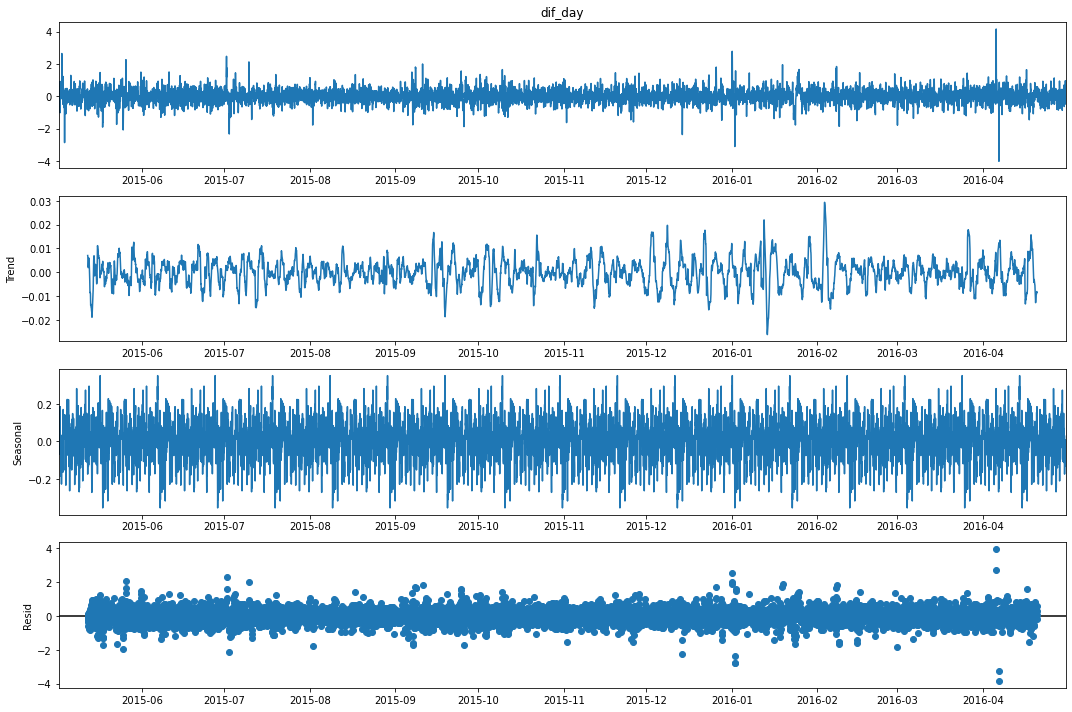

Критерий Дики-Фуллера: p=0.000000


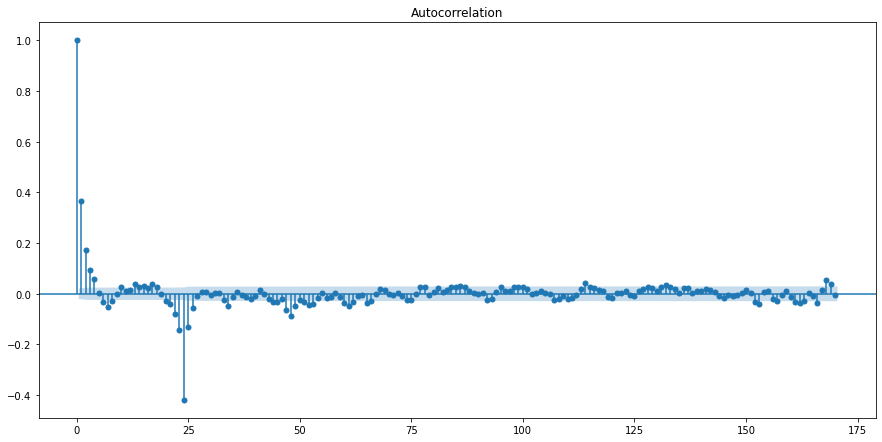

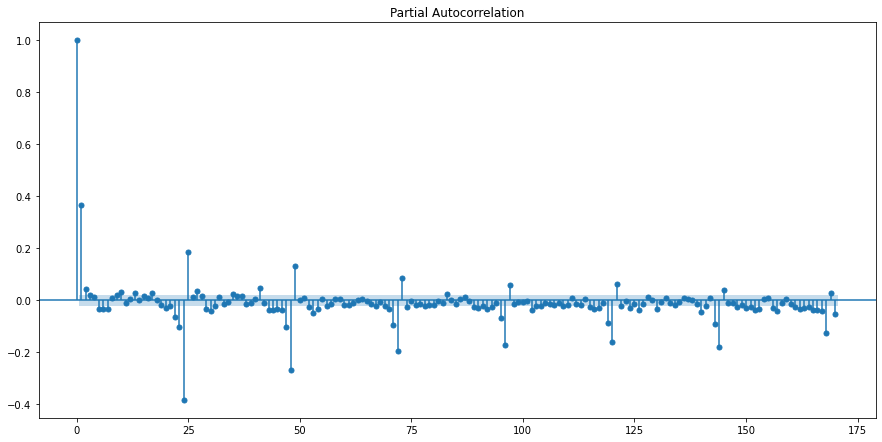

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 1, зона: 1180


<Figure size 1080x720 with 0 Axes>

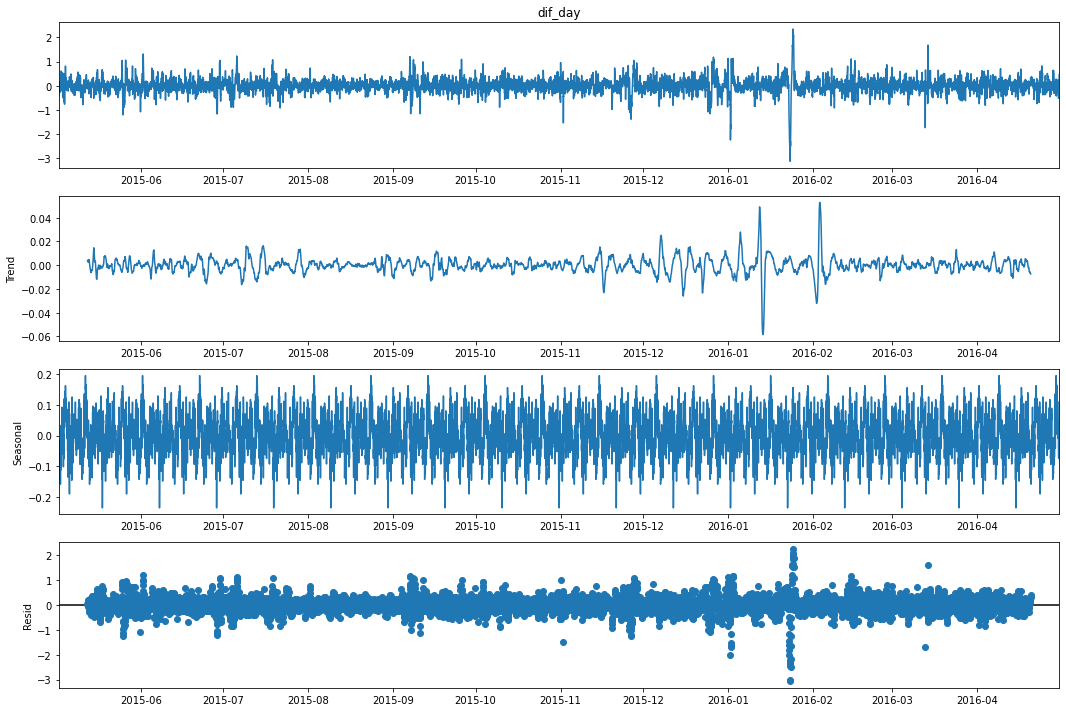

Критерий Дики-Фуллера: p=0.000000


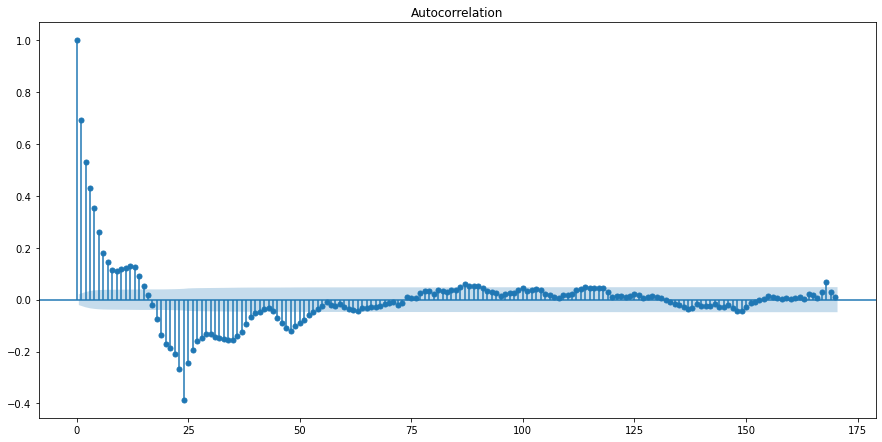

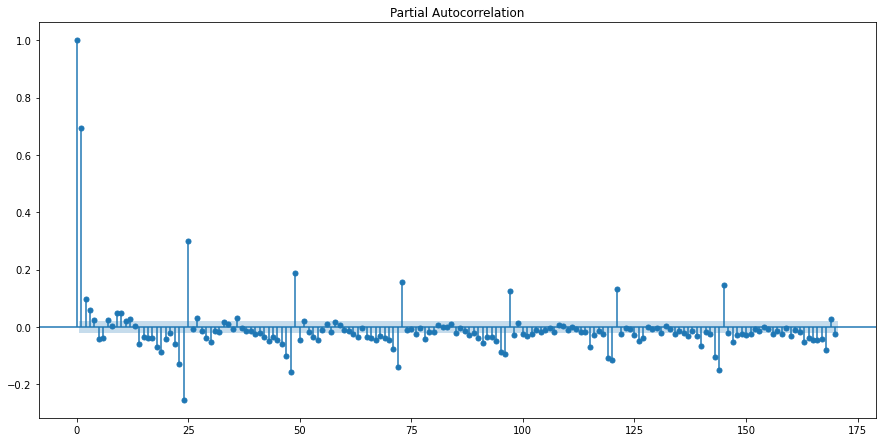

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 2, зона: 1229


<Figure size 1080x720 with 0 Axes>

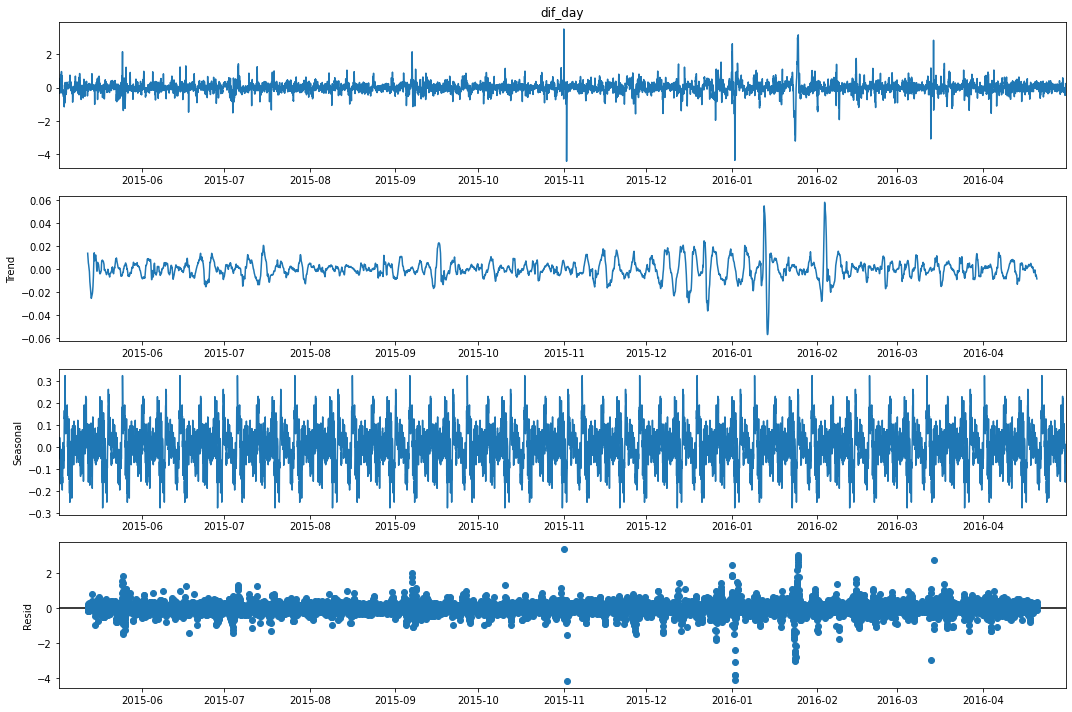

Критерий Дики-Фуллера: p=0.000000


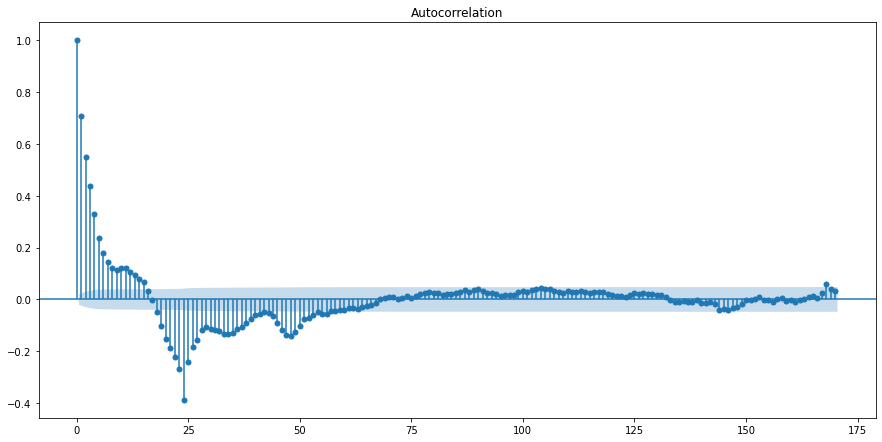

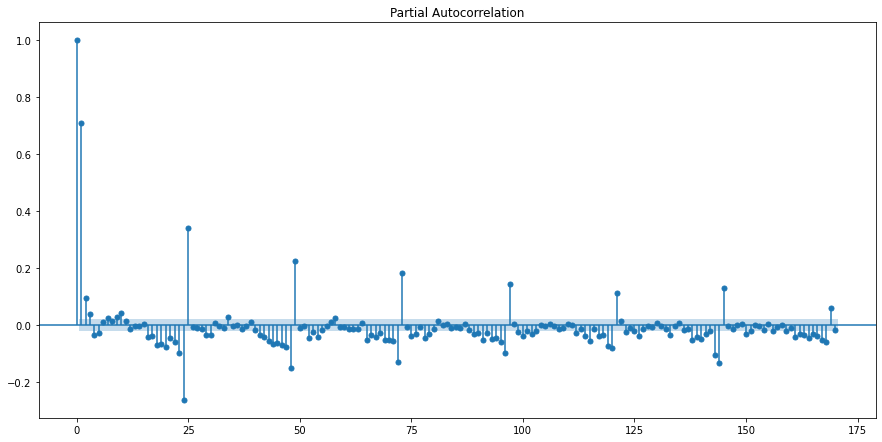

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 3, зона: 1326


<Figure size 1080x720 with 0 Axes>

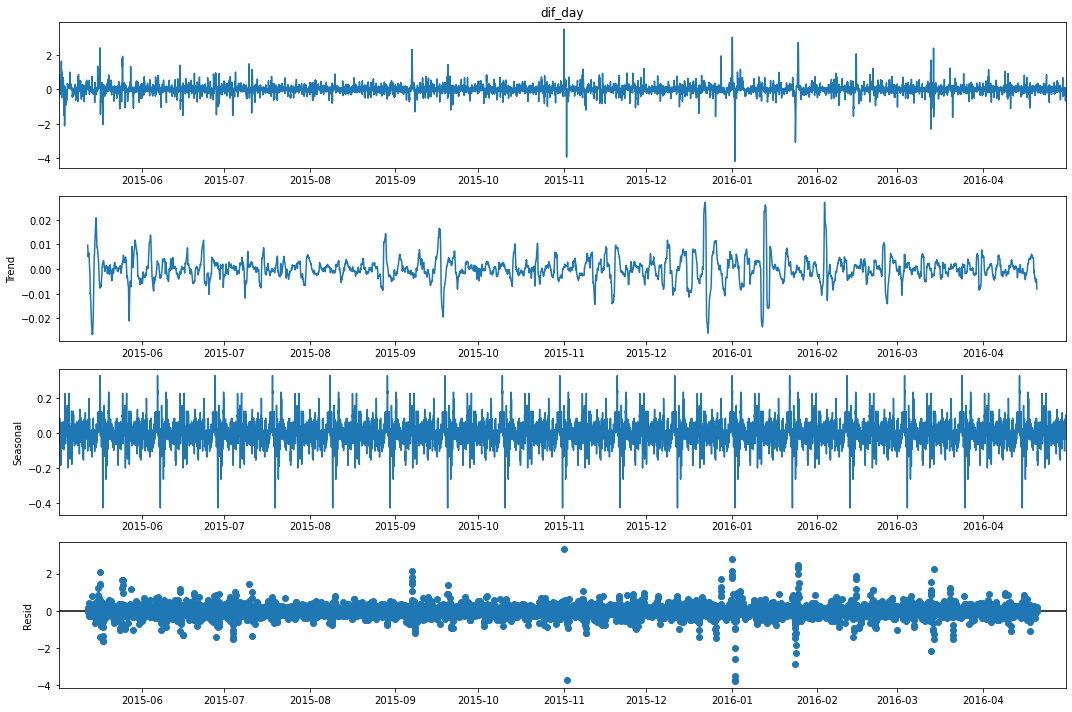

Критерий Дики-Фуллера: p=0.000000


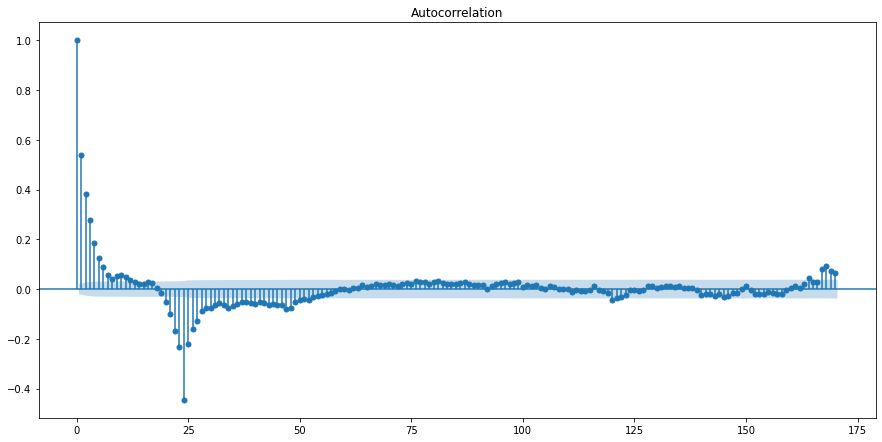

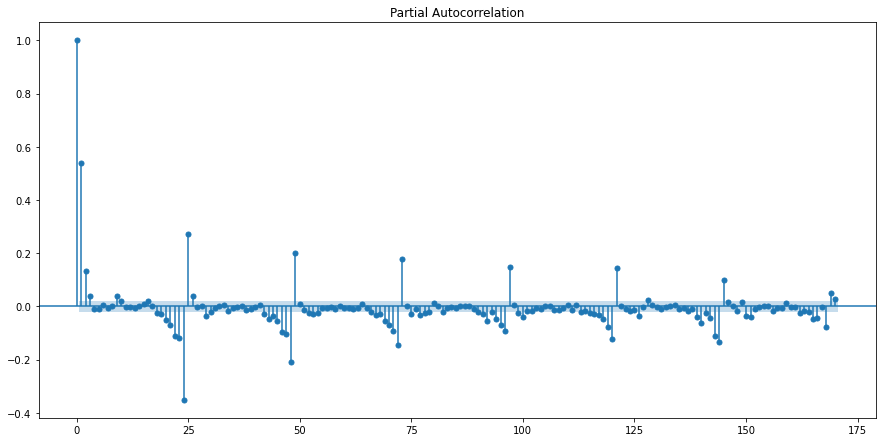

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 4, зона: 1333


<Figure size 1080x720 with 0 Axes>

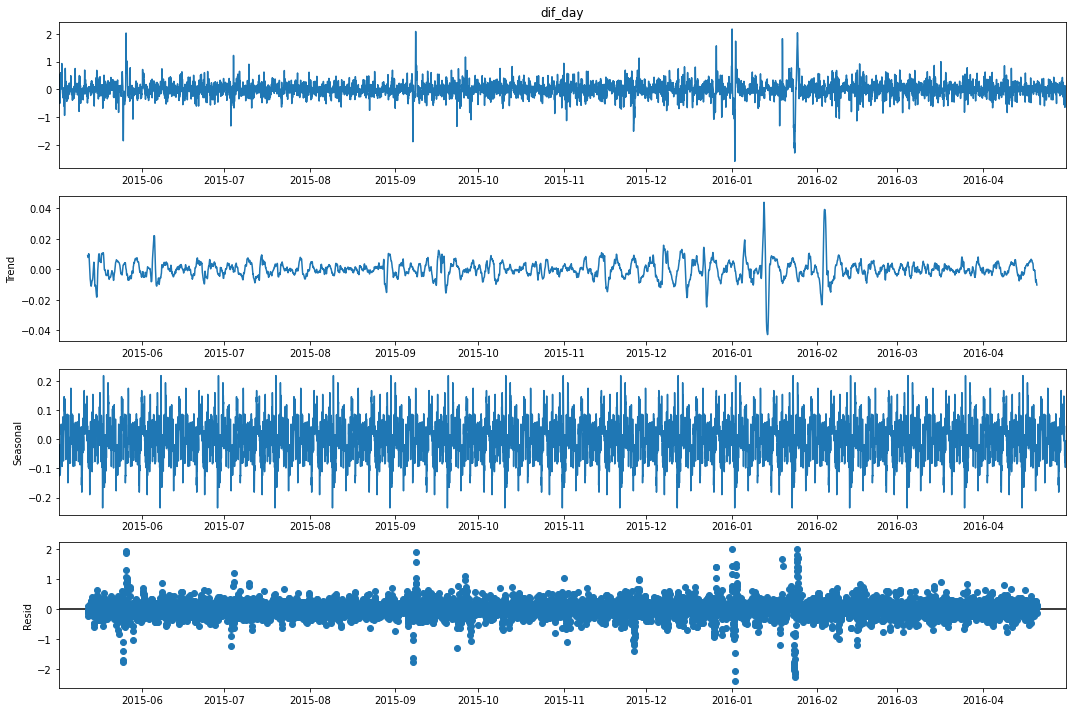

Критерий Дики-Фуллера: p=0.000000


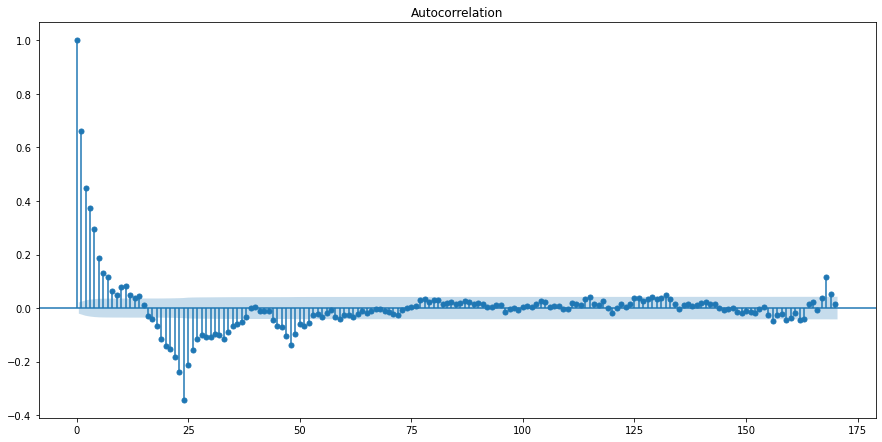

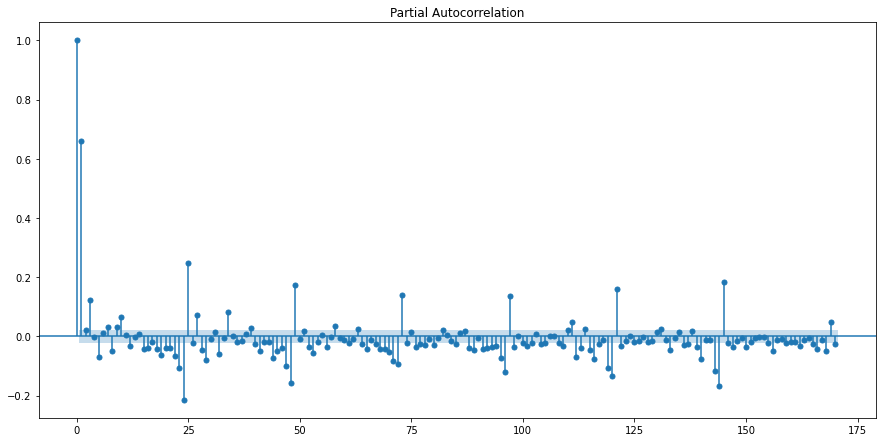

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 5, зона: 1387


<Figure size 1080x720 with 0 Axes>

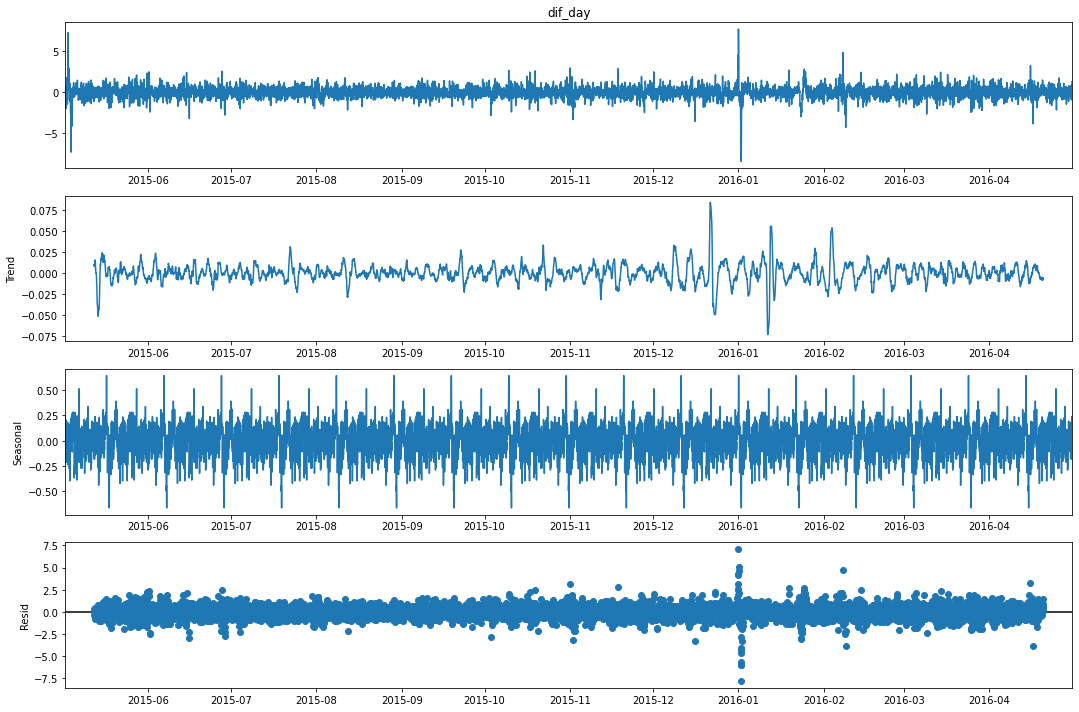

Критерий Дики-Фуллера: p=0.000000


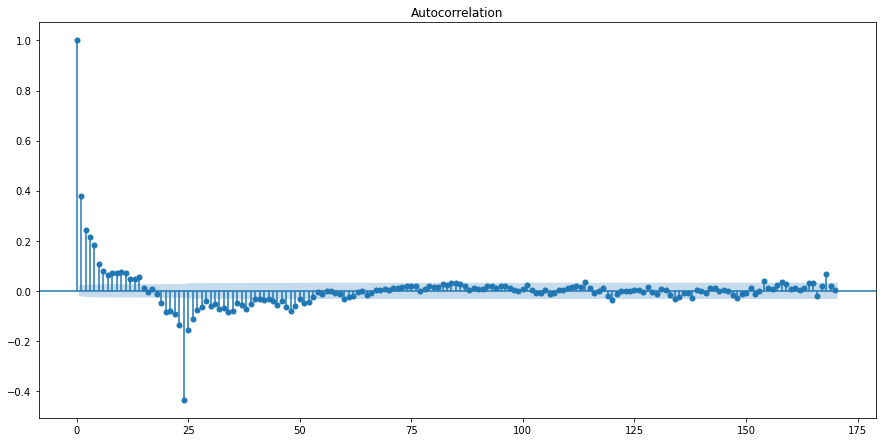

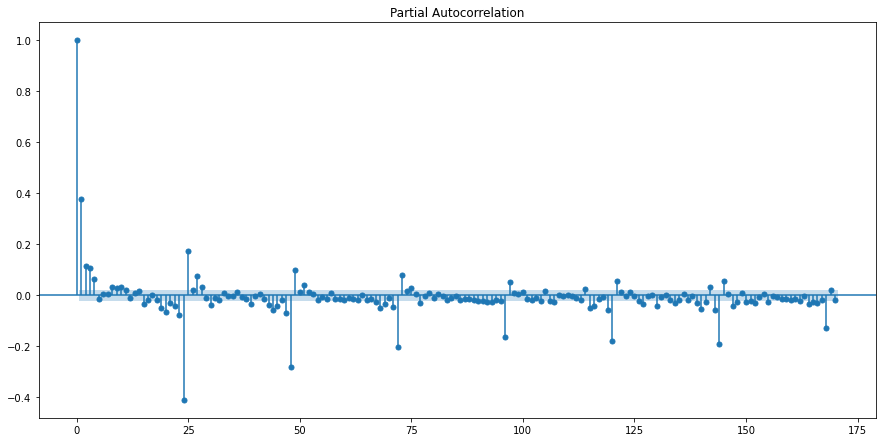

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 6, зона: 1530


<Figure size 1080x720 with 0 Axes>

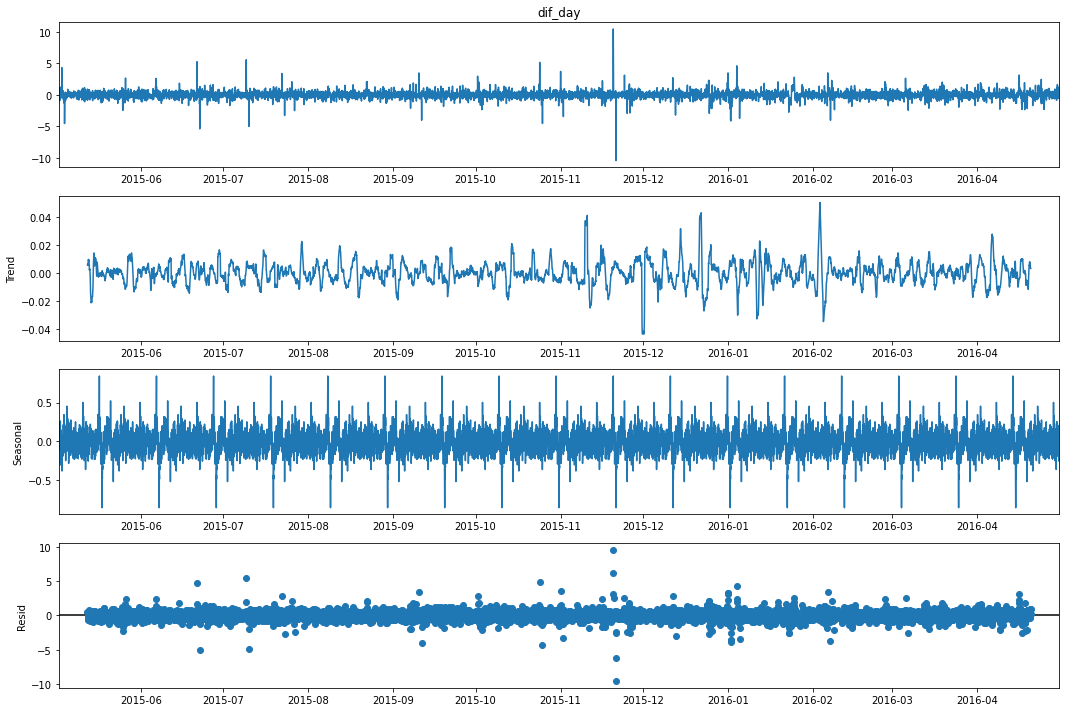

Критерий Дики-Фуллера: p=0.000000


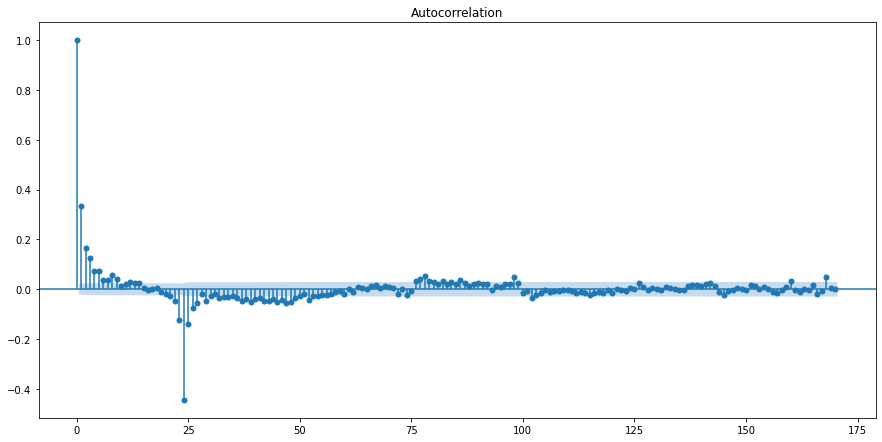

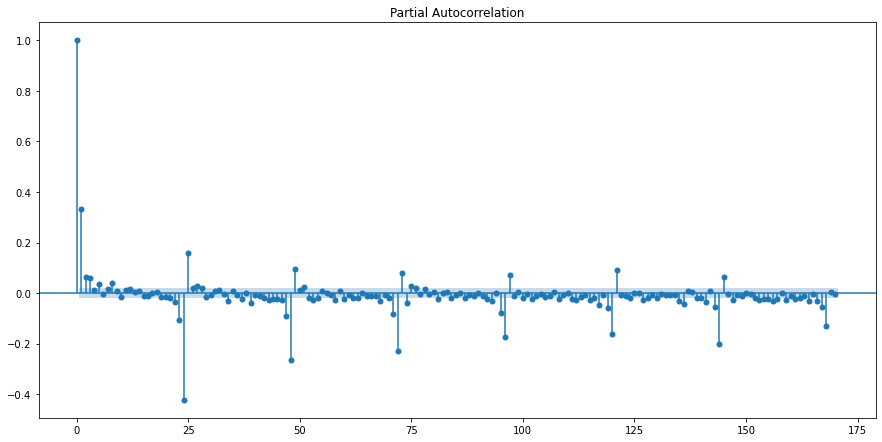

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 7, зона: 1533


<Figure size 1080x720 with 0 Axes>

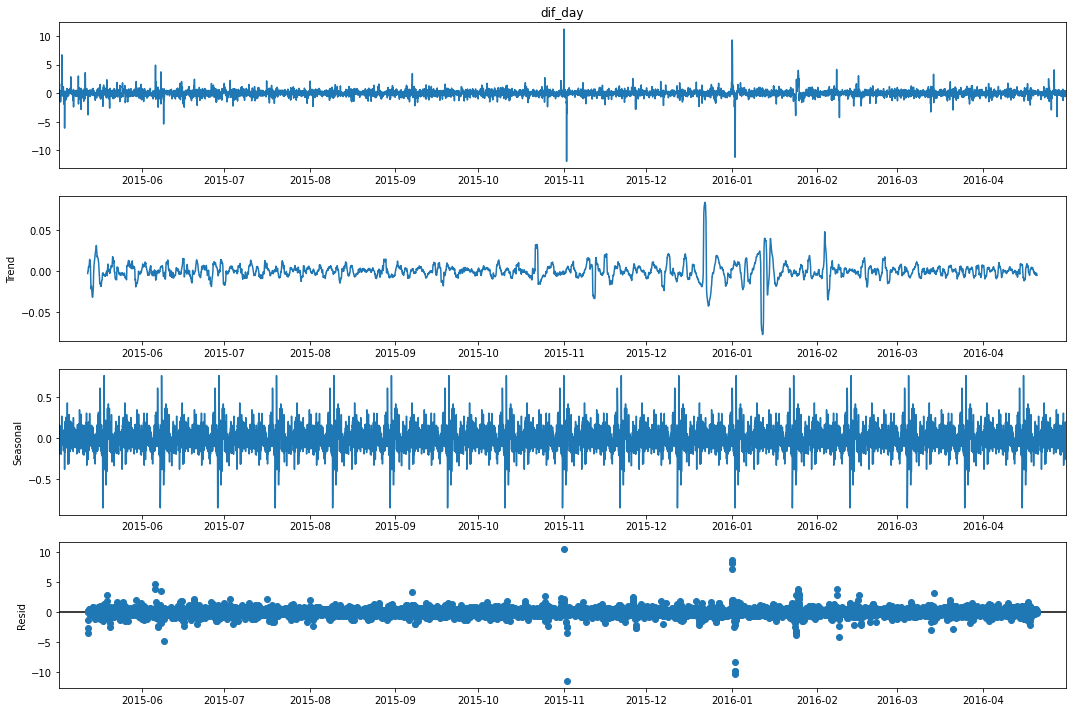

Критерий Дики-Фуллера: p=0.000000


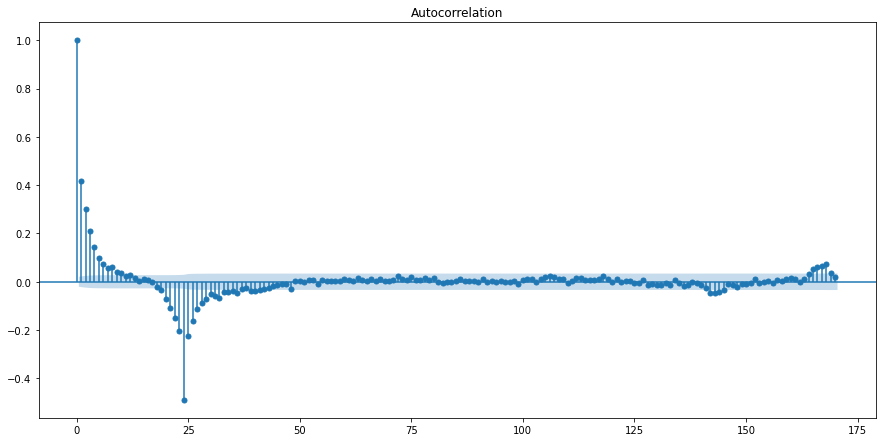

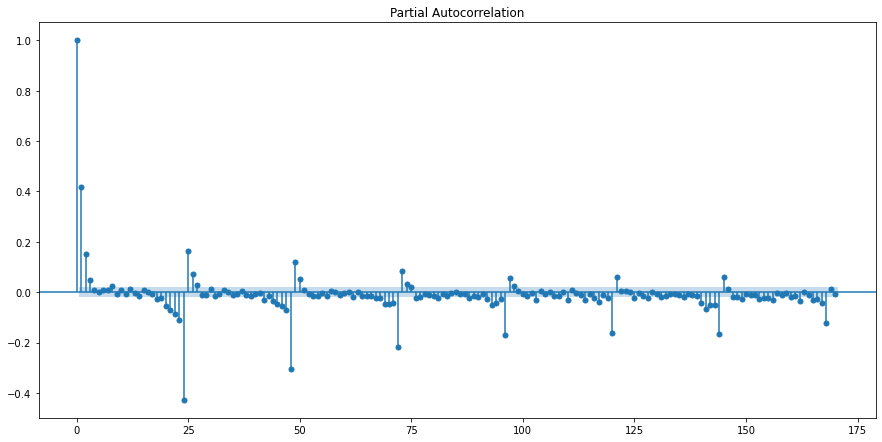

STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".
 Центр кластера 8, зона: 2068


<Figure size 1080x720 with 0 Axes>

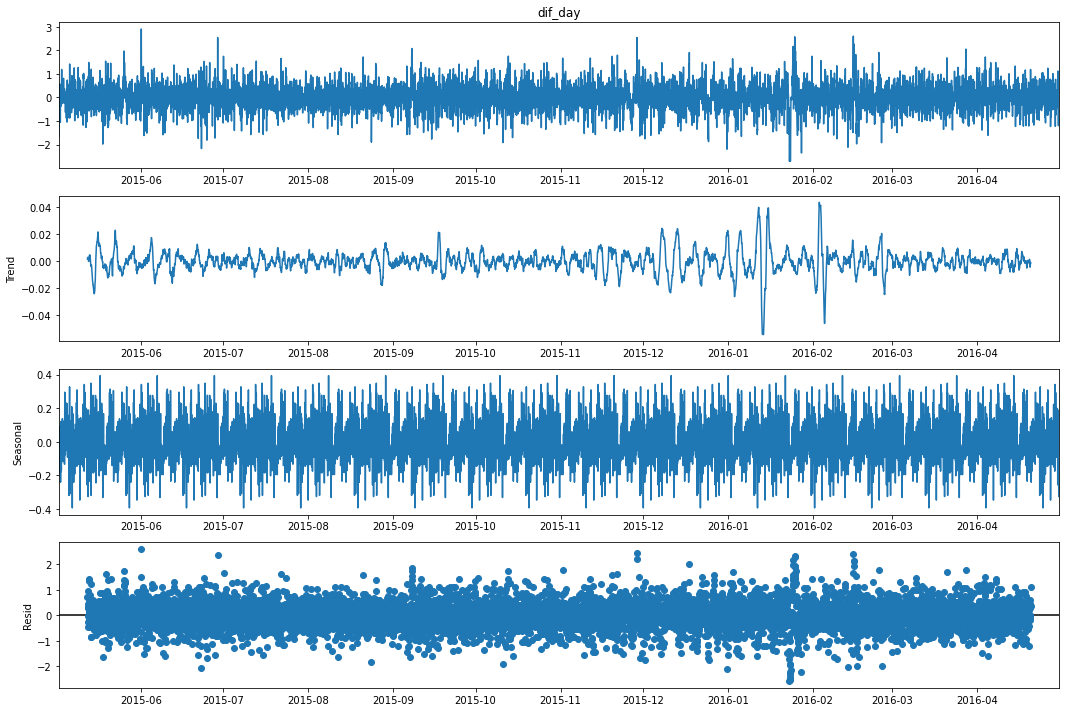

Критерий Дики-Фуллера: p=0.000000


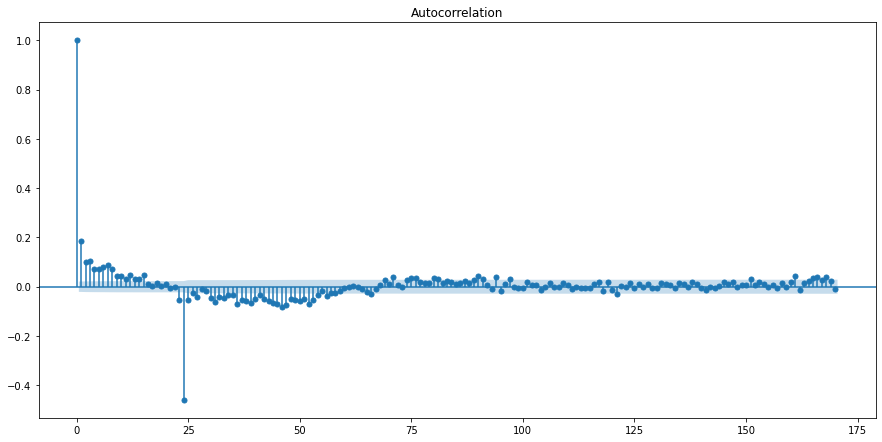

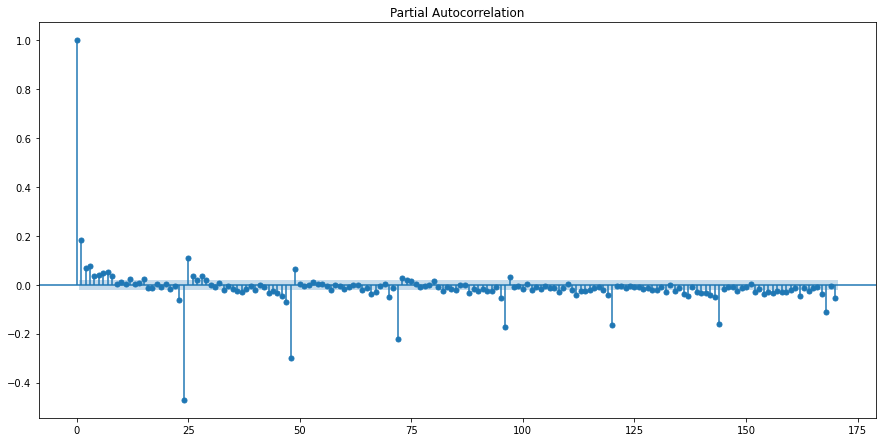

In [66]:
resid = {}
for cl in range(len(lab_a)):
    y = res_sc.loc[dicts[cl], '2015-05-01':]  # рассматриваем только центры кластеров 
    model = LinearRegression()    
    res = model.fit(reg_all, y)
    y_pred = res.predict(reg_all)
    mean_squared_error(y, y_pred)
    
    # Остатки регрессии:
    comparison = pd.DataFrame({'Actual':y, 'Predicted':y_pred, 'dif':y-y_pred})
   
    
    # Сделаем АРИМУ по остаткам (разности между предикторами регрессоров и значениями):
    # Из-за ограниченности вычислительных ресурсов, - расчет производим, начиная с даты '2015-05-01' по 2016-04-30'

    compar = comparison.copy()
    compar.index = pd.to_datetime(compar.index)
    resid[cl] =  compar # формируем словарь остатков
    
    # Проведем сезонное (суточное) дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:
    compar['dif_day'] = compar['dif'] - compar['dif'].shift(24)
    # print ('STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)"')
    
    plt.figure(figsize(15,10))
    print(f'STL разложение временного ряда "Остатки (разность между предикторами регрессоров и значениями)".\n Центр кластера {cl}, зона: {dicts[cl]}')
    sm.tsa.seasonal_decompose(compar['dif_day'][24:], period=500).plot()
    
    pylab.show()

    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(compar['dif_day'][24:])[1])

    # Посмотрим на ACF и PACF полученного ряда:

    plt.figure(figsize(15,16))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(compar['dif_day'][24:], lags=170, ax=ax)
    plt.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(compar['dif_day'][24:], lags=170, ax=ax)
    plt.show()

Глядя на наши графики, Выбираем начальные приближения: Q=1, q=4, P=6, p=1
(в том числе исходя из разумной достаточности и ограничений вычислительных ресурсов)

Из-за ограниченности памяти ( 16 ГБ) ограничиваю параметр P=4 (Иначе вылетает с ошибкой: Unable to allocate 1.85 GiB for an array with shape (8785, 168, 168) and data type float64)

In [67]:
ps = range(0, 2)
d=0
qs = range(0, 5)
Ps = range(0, 5) # Вынужденное ограничение
D=1
Qs = range(0, 2)

In [68]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [69]:
# Рассчет закоментирован,т.к. занимает более 2х часов. Вывожу оптимальные данные:
# results ={}
# for cl in range(4, len(lab_a)): 
    # #results = []
    # best_aic = float("inf")
    # warnings.filterwarnings('ignore')

    # for param in parameters_list:
        # #try except нужен, потому что на некоторых наборах параметров модель не обучается
        # try:
            # model=sm.tsa.statespace.SARIMAX(resid[cl]['dif'],  order=(param[0], d, param[1]), 
                                        # seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=10)
        # #выводим параметры, на которых модель не обучается и переходим к следующему набору
        # except ValueError:
            # print('wrong parameters:', param)
            # continue
        # aic = model.aic
        # print ('parameters:{} have aic value {}'.format(param, aic))
        # #сохраняем лучшую модель, aic, параметры
        # if aic < best_aic:
            # best_model = model
            # best_aic = aic
            # best_param = param
        # #results.append([param, model.aic])
    # results[cl] = [best_aic, best_param] 
    # print (f'best_param:{results[cl][1]} have best_aic {results[cl][0]} для кластера {cl}')  
    # warnings.filterwarnings('default')
# # exog=reg_all решил не использовать, система виснет из-за ограниченности системных ресурсов. 
# # Да и сами регрессоры уже учтены в предикторах, на основе ктр и анализируем остатки 

In [70]:
results = {4: [-7189.961395225622, (1, 3, 4, 1)],
 5: [11184.8198029572, (1, 4, 1, 1)],
 6: [9017.855472946092, (1, 3, 1, 1)],
 7: [9327.166986579006, (1, 2, 0, 1)],
 8: [7762.664819127996, (1, 2, 1, 1)],
 1: [-6846.0, (1, 0, 0, 1)],
 0: [3229.0, (0, 4, 1, 1)],
 2: [-3850.0, (1, 0, 0, 1)],
 3: [-4781.0, (1, 1, 0, 1)]}

                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(0, 0, 4)x(1, 1, [1], 24)   Log Likelihood               -1607.841
Date:                              Mon, 04 Jan 2021   AIC                           3229.681
Time:                                      10:57:45   BIC                           3279.227
Sample:                                  05-01-2015   HQIC                          3246.563
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3791      0.007     58.284      0.000       0.366       0.392
ma.L2          0.16

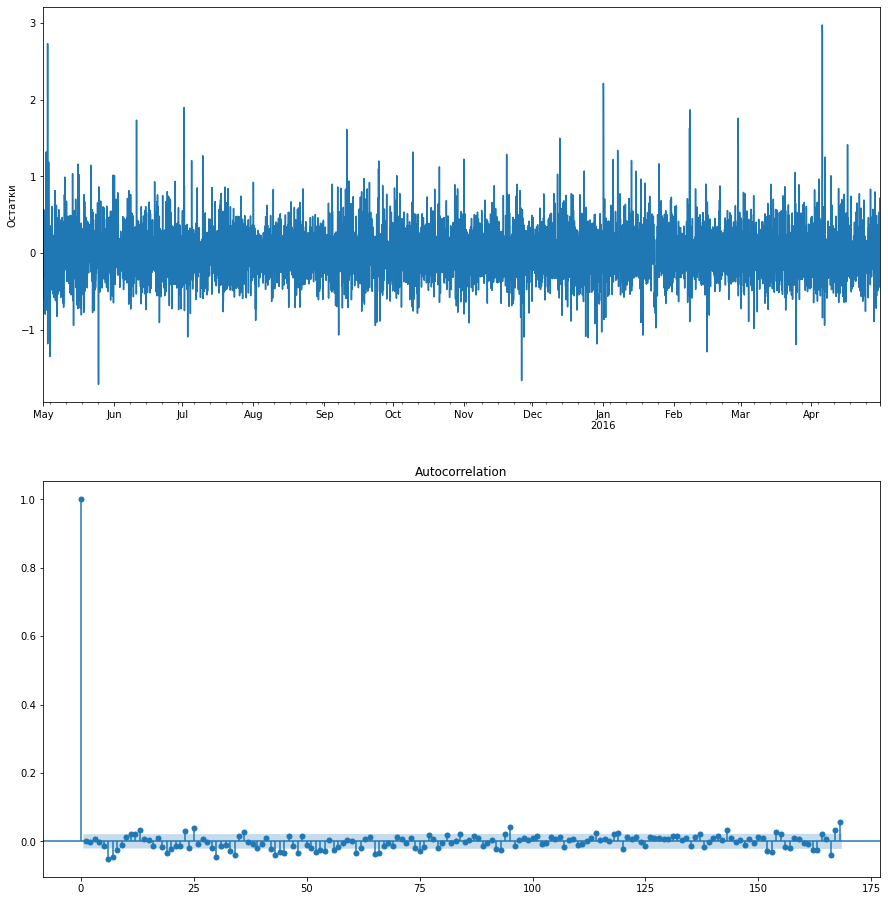

Критерий Стьюдента: p=0.967948
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood                3426.044
Date:                              Mon, 04 Jan 2021   AIC                          -6846.088
Time:                                      10:57:58   BIC                          -6824.855
Sample:                                  05-01-2015   HQIC                         -6838.853
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7026      0.004 

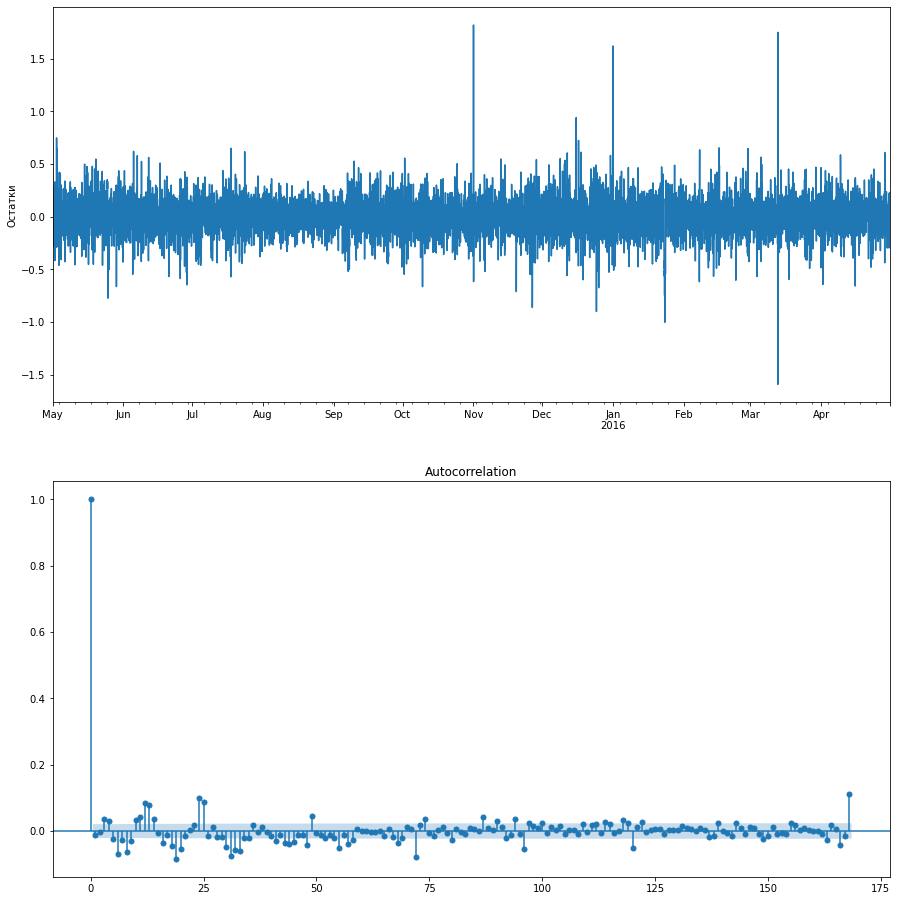

Критерий Стьюдента: p=0.945927
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood                1928.465
Date:                              Mon, 04 Jan 2021   AIC                          -3850.931
Time:                                      10:58:10   BIC                          -3829.697
Sample:                                  05-01-2015   HQIC                         -3843.696
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7315      0.003 

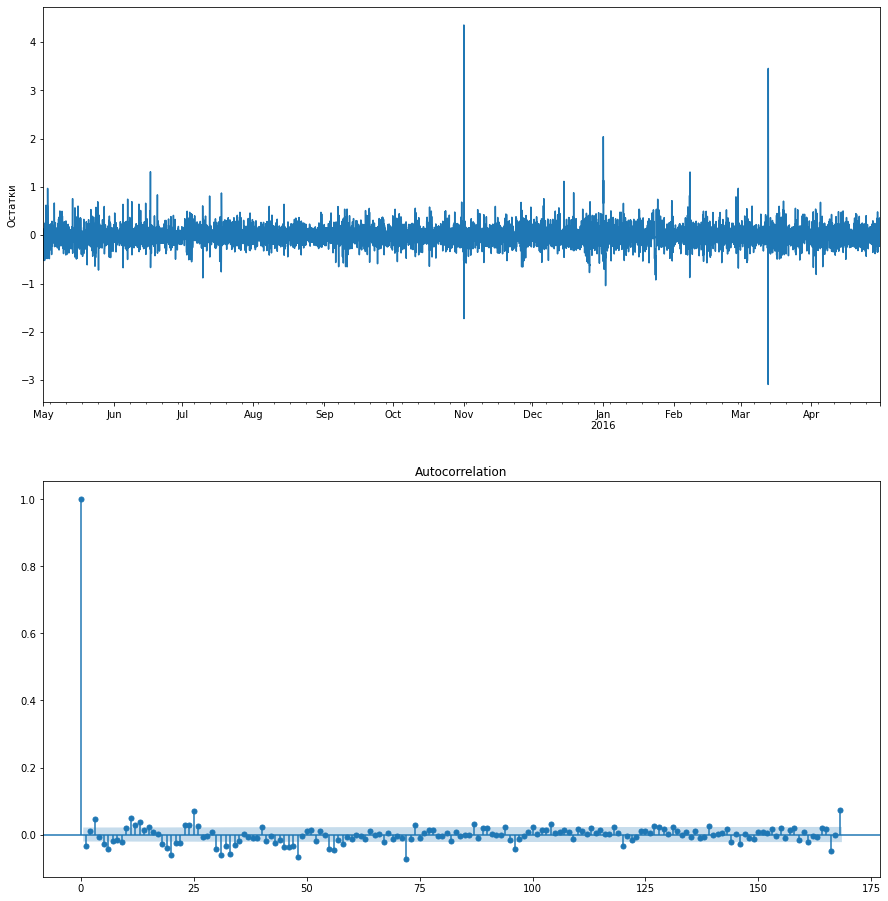

Критерий Стьюдента: p=0.922487
Критерий Дики-Фуллера: p=0.000000
                                     SARIMAX Results                                      
Dep. Variable:                                dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood                2394.497
Date:                            Mon, 04 Jan 2021   AIC                          -4780.993
Time:                                    10:58:24   BIC                          -4752.681
Sample:                                05-01-2015   HQIC                         -4771.346
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7070      0.006    124.374      

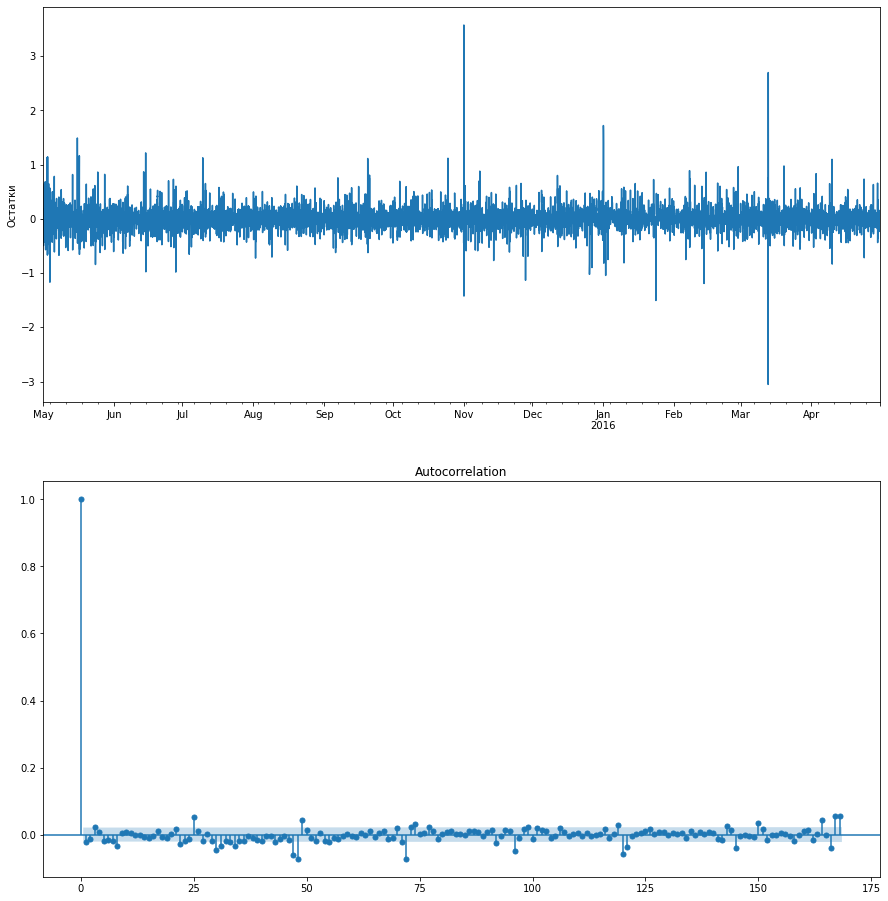

Критерий Стьюдента: p=0.940609
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 3)x(4, 1, [1], 24)   Log Likelihood                3604.962
Date:                              Mon, 04 Jan 2021   AIC                          -7189.925
Time:                                      11:01:53   BIC                          -7119.145
Sample:                                  05-01-2015   HQIC                         -7165.808
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6814      0.016 

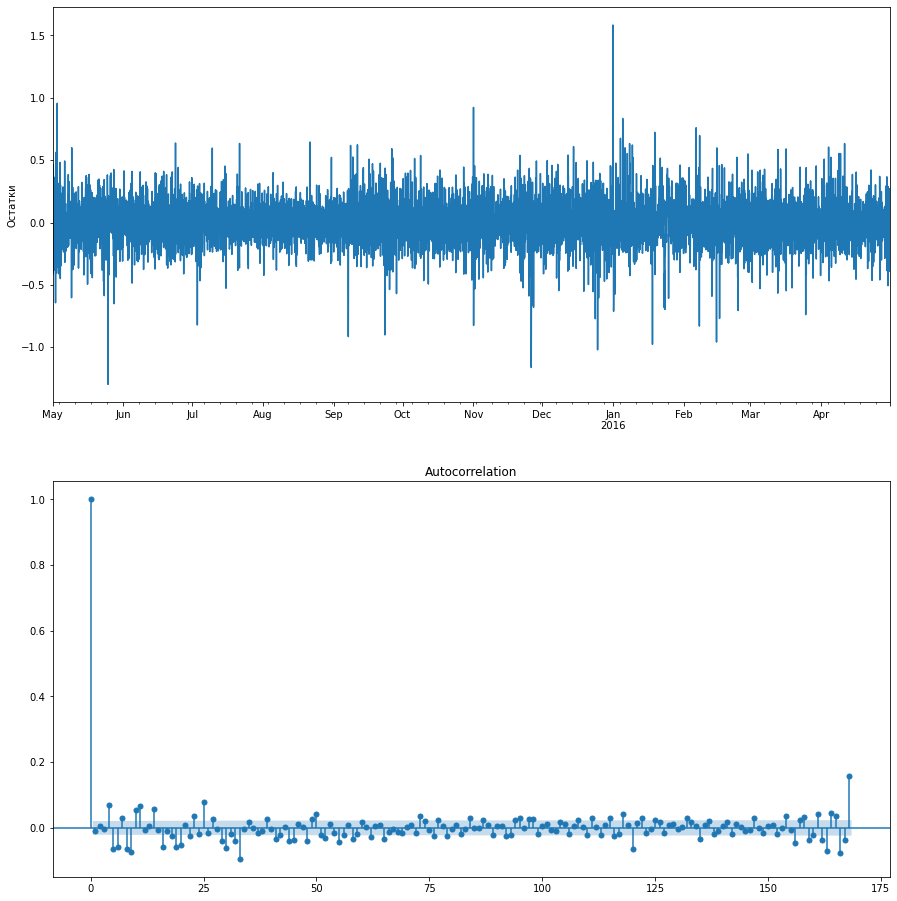

Критерий Стьюдента: p=0.935529
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 4)x(1, 1, [1], 24)   Log Likelihood               -5584.433
Date:                              Mon, 04 Jan 2021   AIC                          11184.866
Time:                                      11:02:31   BIC                          11241.489
Sample:                                  05-01-2015   HQIC                         11204.159
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6243      0.042 

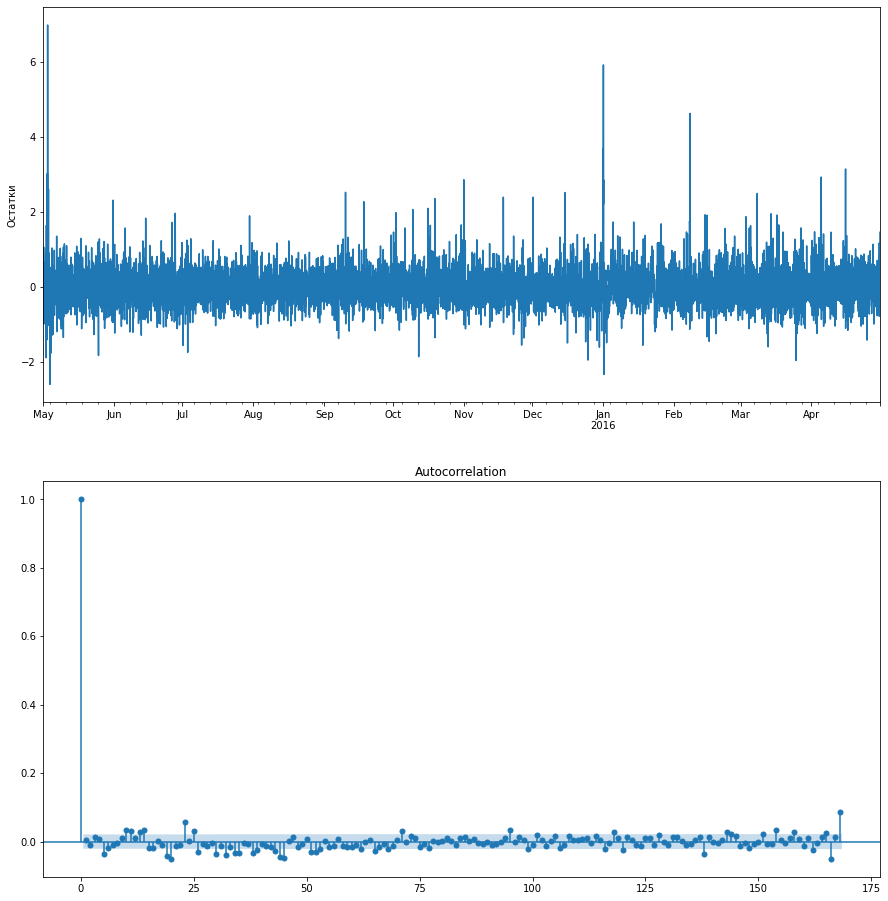

Критерий Стьюдента: p=0.963240
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 24)   Log Likelihood               -4501.923
Date:                              Mon, 04 Jan 2021   AIC                           9017.847
Time:                                      11:03:04   BIC                           9067.393
Sample:                                  05-01-2015   HQIC                          9034.729
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6202      0.054 

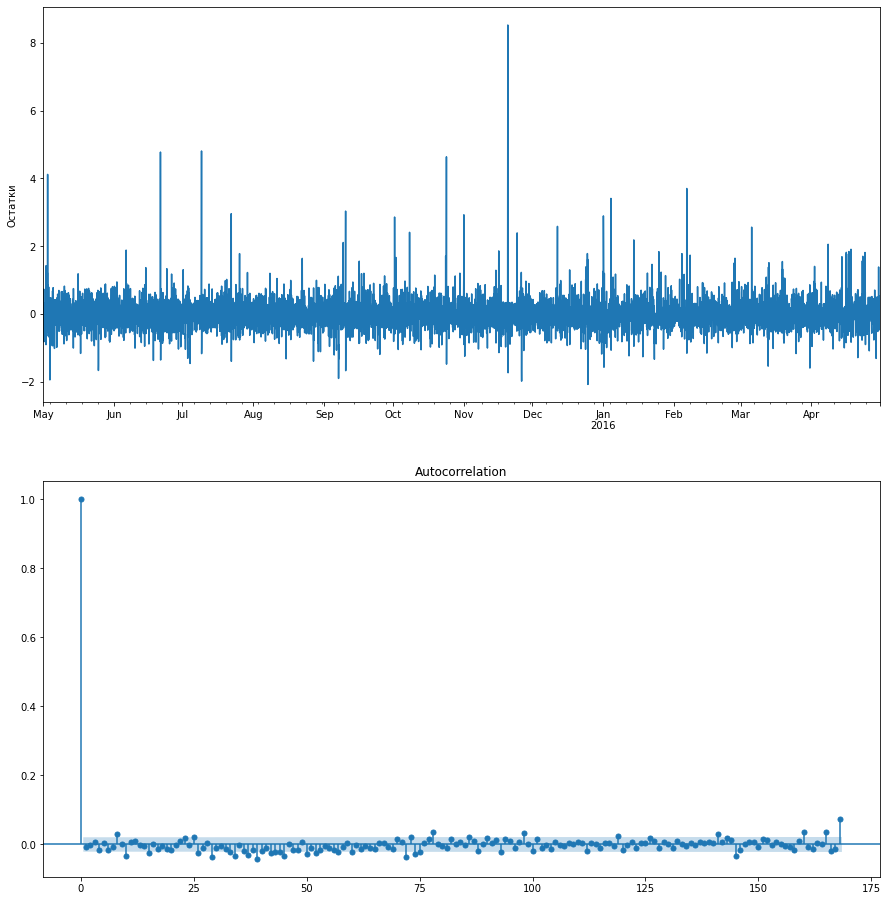

Критерий Стьюдента: p=0.970031
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 24)   Log Likelihood               -4658.584
Date:                              Mon, 04 Jan 2021   AIC                           9327.167
Time:                                      11:03:36   BIC                           9362.557
Sample:                                  05-01-2015   HQIC                          9339.226
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6115      0.015 

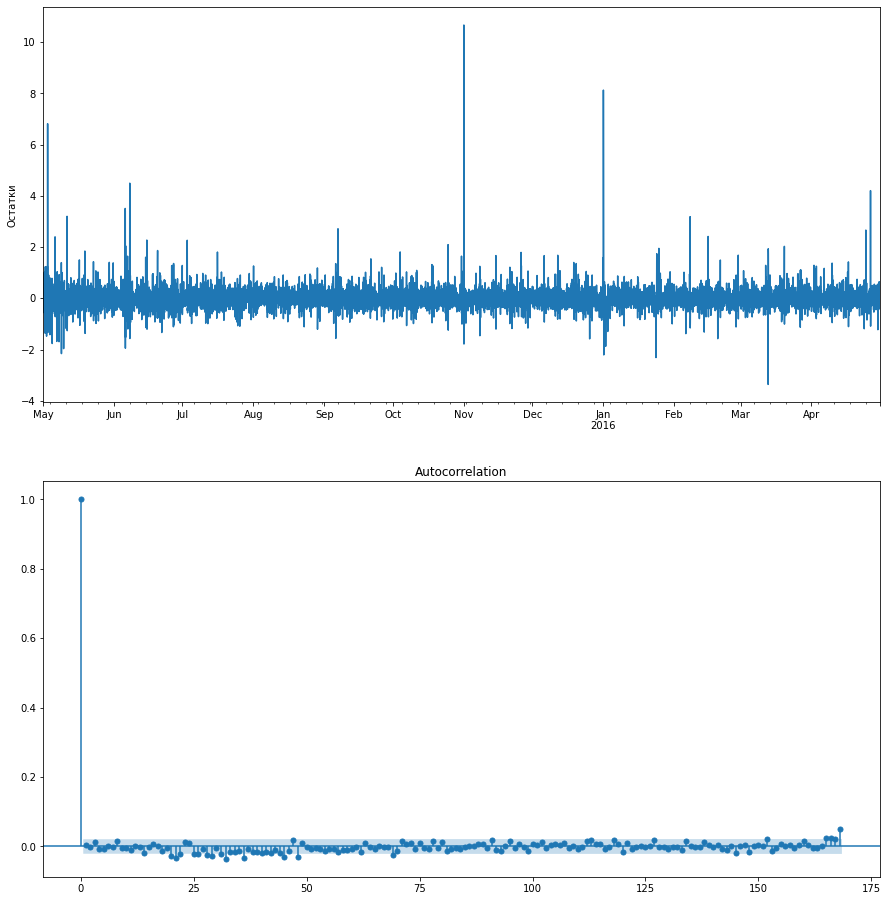

Критерий Стьюдента: p=0.971026
Критерий Дики-Фуллера: p=0.000000
                                      SARIMAX Results                                       
Dep. Variable:                                  dif   No. Observations:                 8784
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 24)   Log Likelihood               -3875.325
Date:                              Mon, 04 Jan 2021   AIC                           7762.651
Time:                                      11:04:07   BIC                           7805.118
Sample:                                  05-01-2015   HQIC                          7777.121
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8912      0.019 

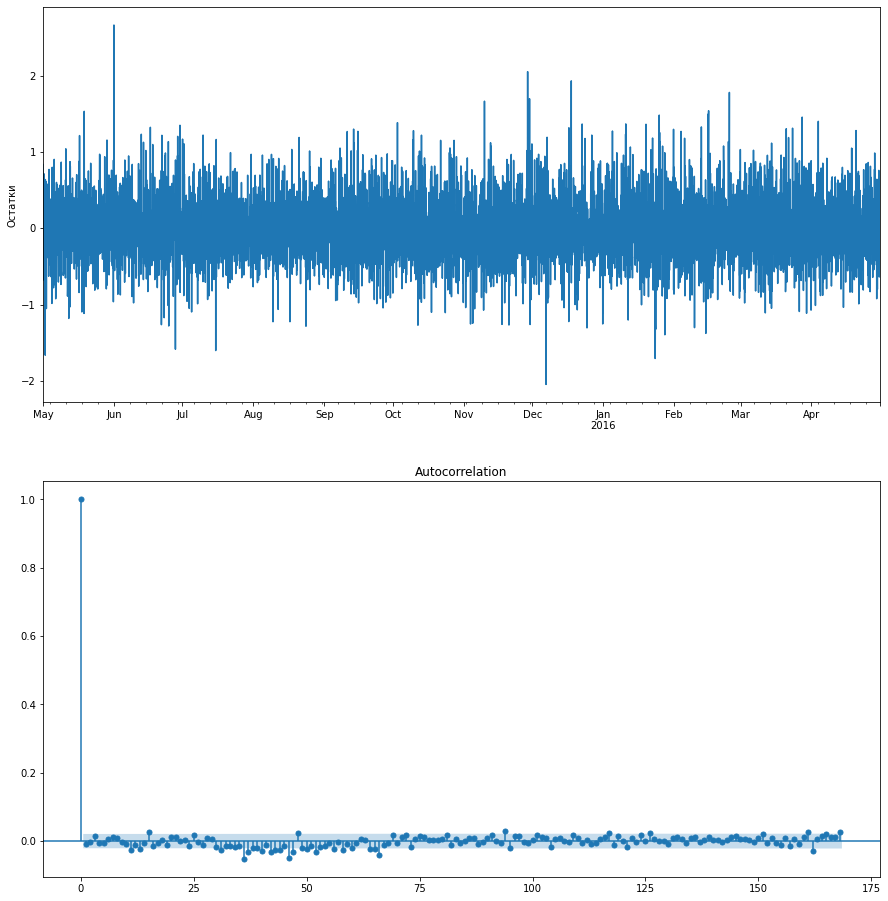

Критерий Стьюдента: p=0.965015
Критерий Дики-Фуллера: p=0.000000


In [71]:
# Отдельно рассчитаем модель на основе наименьшего информационного критерия АКАИКЕ:
model = {}
warnings.filterwarnings('ignore')
for cl in range(len(lab_a)):
    
    model[cl] = sm.tsa.statespace.SARIMAX(resid[cl]['dif'],  order=(results[cl][1][0], d, results[cl][1][1]), 
                                    seasonal_order=(results[cl][1][2], D, results[cl][1][3], 24)).fit(disp=-1, maxiter=10)

    print(model[cl].summary())

    # Посмотрим на остатки более внимательно:

    plt.figure(figsize(15,16))

    plt.subplot(211)
    model[cl].resid.plot()
    plt.ylabel('Остатки')

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(model[cl].resid.values.squeeze(), lags=168, ax=ax)
    plt.show()


    print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model[cl].resid, 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model[cl].resid)[1])
# warnings.filterwarnings('default')

r2_score для кластера 0 : 0.8059711272365251


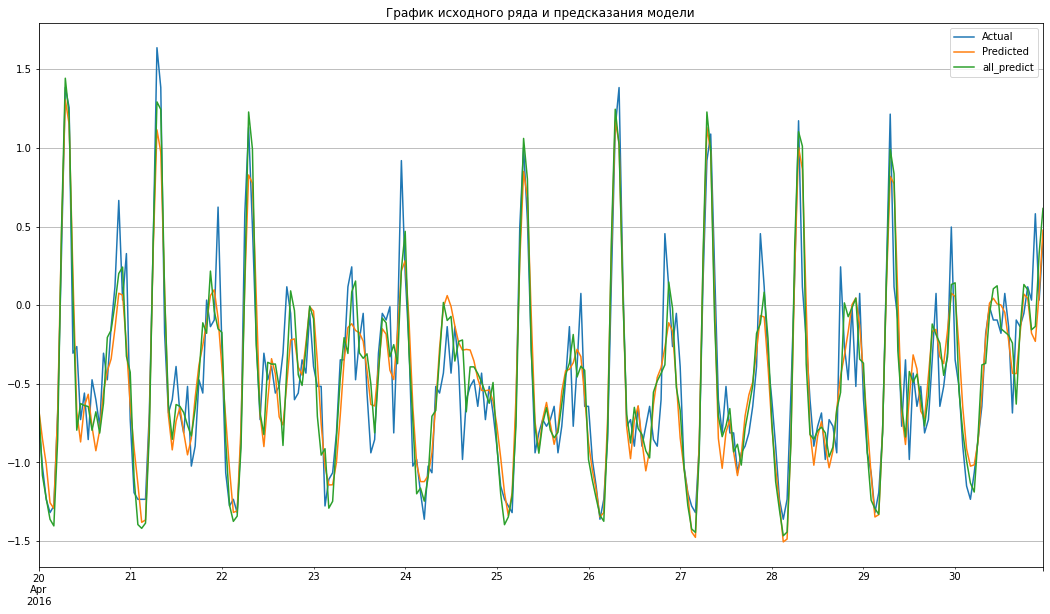

r2_score для кластера 1 : 0.9635066011282392


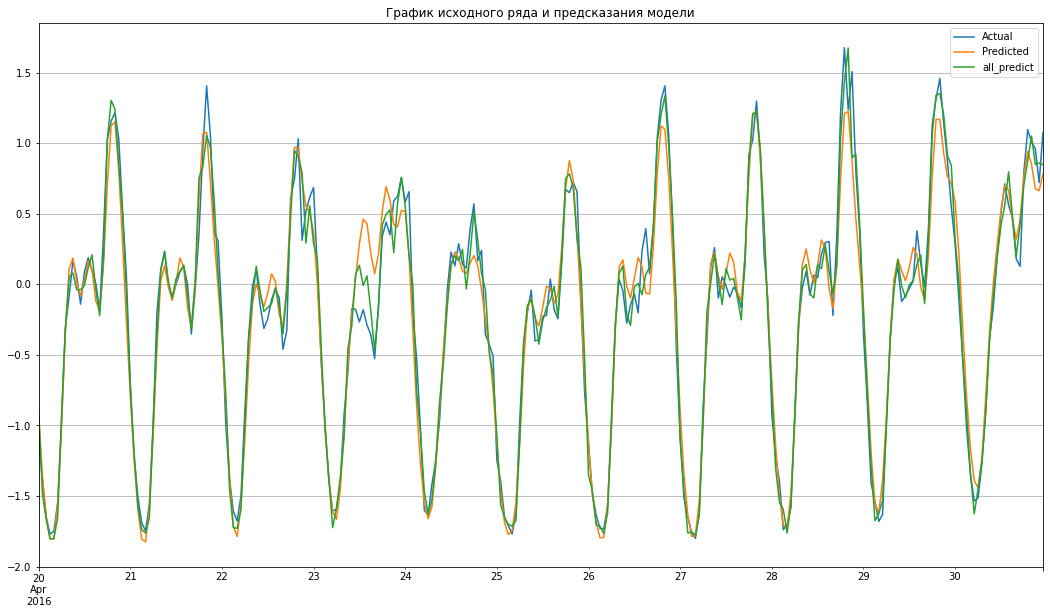

r2_score для кластера 2 : 0.9464621545710792


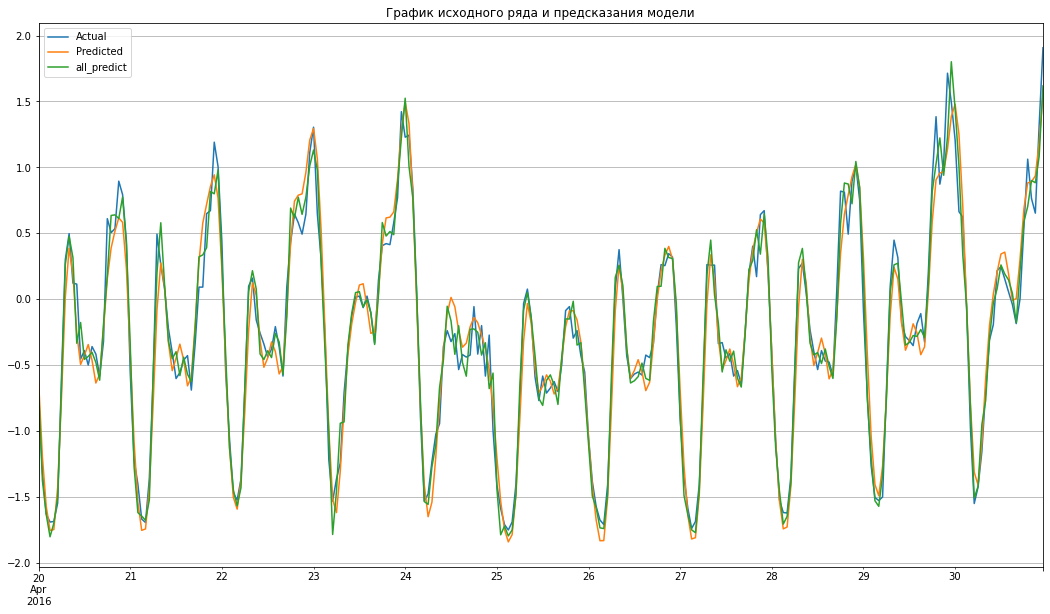

r2_score для кластера 3 : 0.9084913569715816


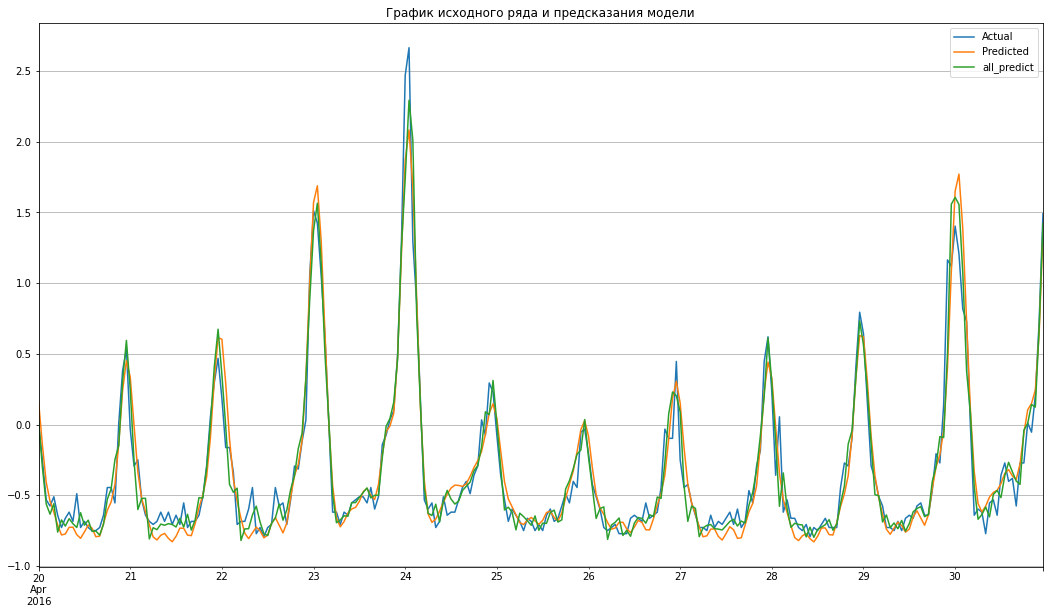

r2_score для кластера 4 : 0.9663571336090393


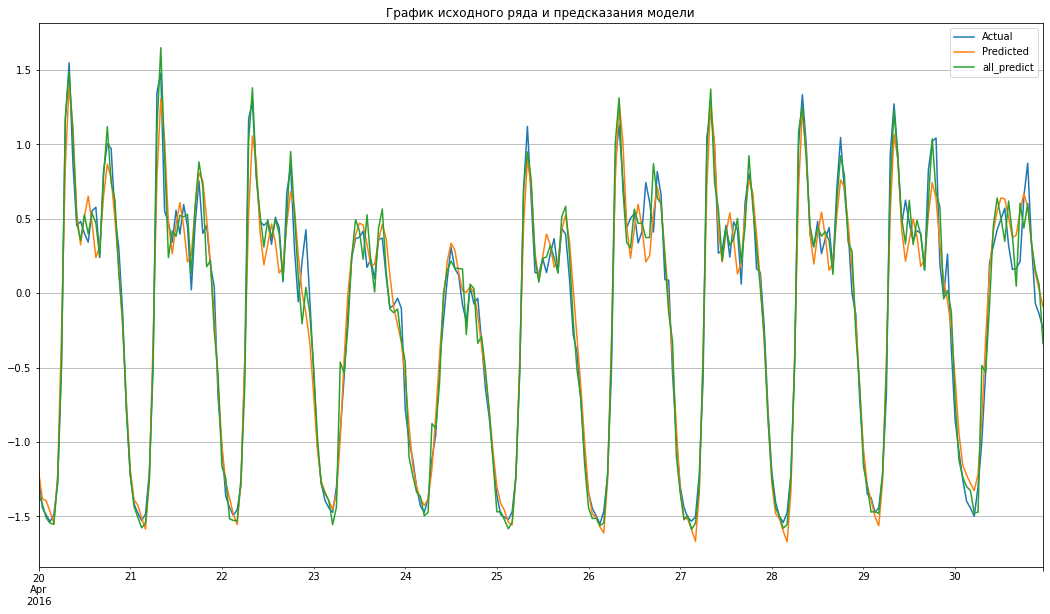

r2_score для кластера 5 : 0.739891710343645


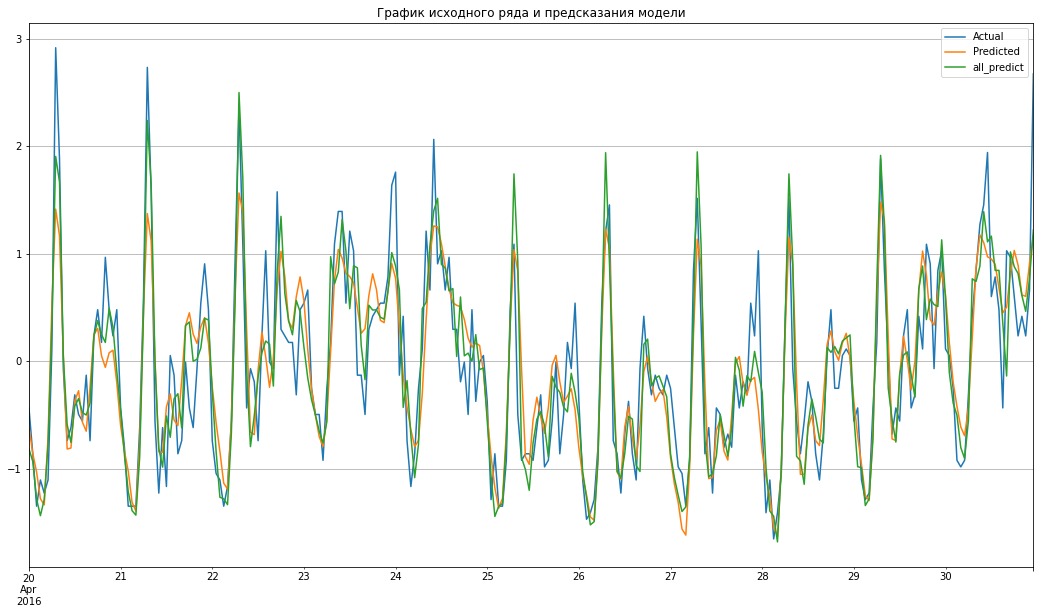

r2_score для кластера 6 : 0.7889800256667725


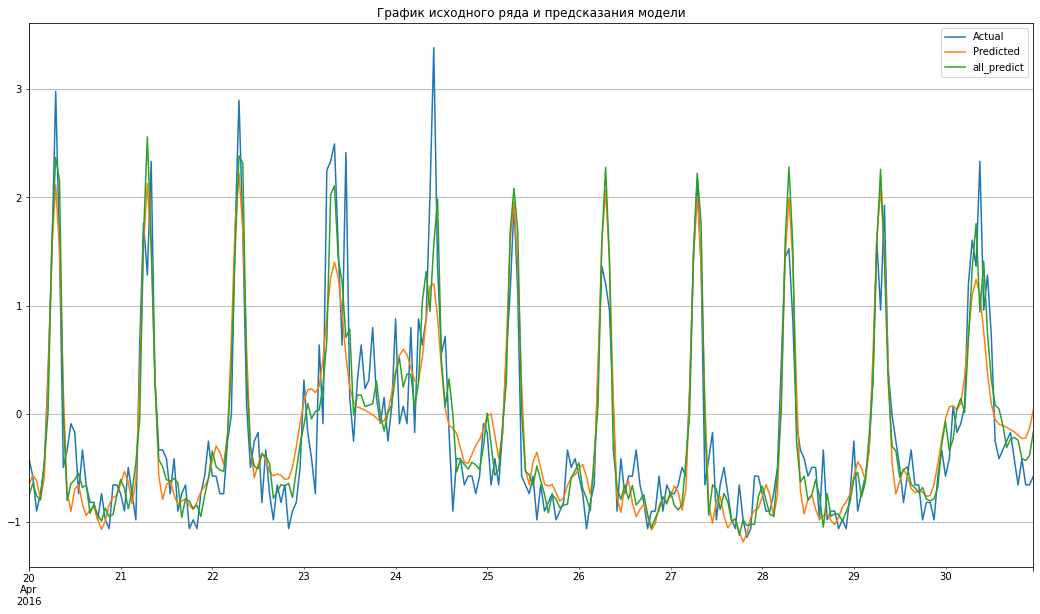

r2_score для кластера 7 : 0.7156675831540625


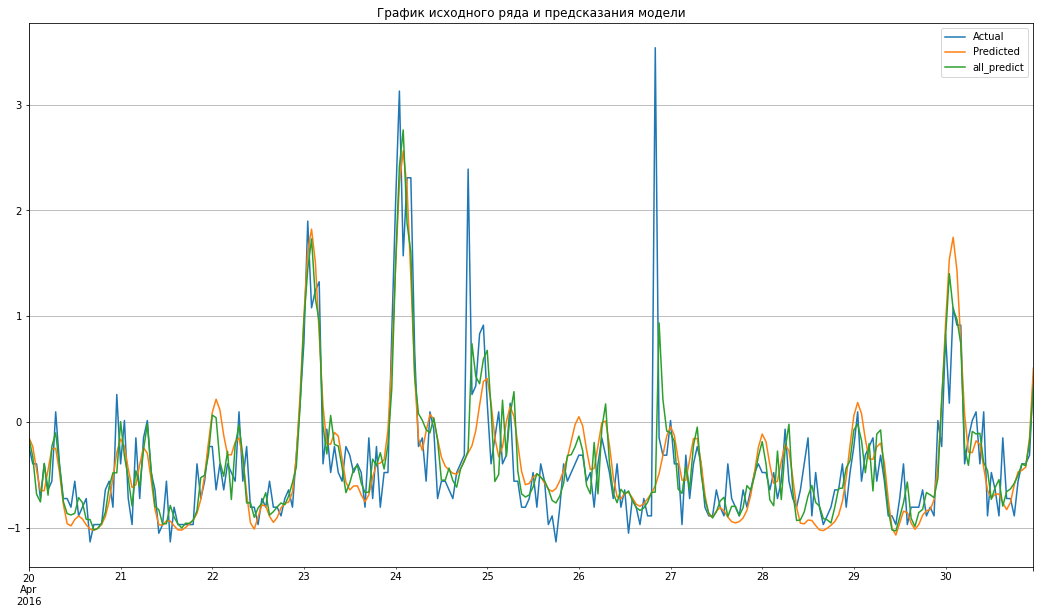

r2_score для кластера 8 : 0.8749829436236664


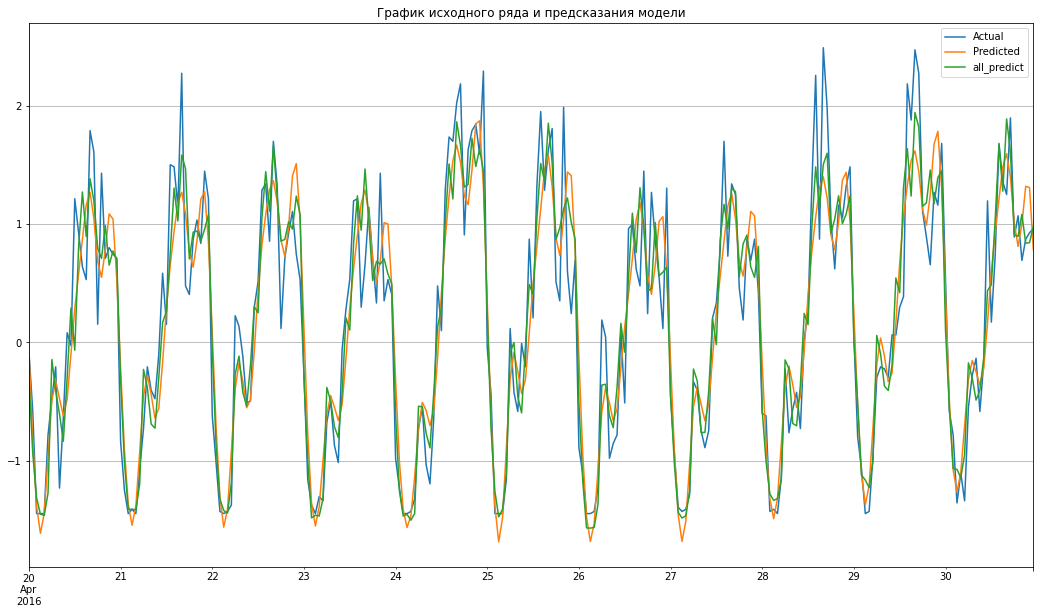

In [72]:
for cl in range(len(lab_a)):

# Проанализируем качество построенных моделей
#resid_part = resid.loc['2016-01-01' :, 'Actual':'Predicted']

# Соединим предсказательные части по регрессионному анализу и ARIMA:
    resid[cl]['all_predict'] = resid[cl]['Predicted'] + model[cl].fittedvalues
    
    resid[cl].loc['2016-04-20' : '2016-04-30',['Actual', 'Predicted', 'all_predict']].plot(figsize=(18,10))
    plt.title('График исходного ряда и предсказания модели')
    plt.grid(True)
    print(f'r2_score для кластера {cl} : {r2_score(resid[cl]["Actual"], resid[cl]["all_predict"])}')
    plt.show()

In [73]:
r2_score(resid[cl]['Actual'], resid[cl]['all_predict'])

0.8749829436236664

#### 5.1 Прорисовка кластеров на динамической карте Нью-Йорка

In [74]:
# Формирование Data Frame для построения кластеров на карте (основа взята из 2ой недели)

regions = pd.read_csv('regions.csv', delimiter=';')


In [75]:
regions

region       west       east      south      north
0          1 -74.255590 -74.244478  40.496120  40.504508
1          2 -74.255590 -74.244478  40.504508  40.512896
2          3 -74.255590 -74.244478  40.512896  40.521285
3          4 -74.255590 -74.244478  40.521285  40.529673
4          5 -74.255590 -74.244478  40.529673  40.538061
...      ...        ...        ...        ...        ...
2495    2496 -73.711122 -73.700010  40.873589  40.881977
2496    2497 -73.711122 -73.700010  40.881977  40.890365
2497    2498 -73.711122 -73.700010  40.890365  40.898754
2498    2499 -73.711122 -73.700010  40.898754  40.907142
2499    2500 -73.711122 -73.700010  40.907142  40.915530

[2500 rows x 5 columns]

In [76]:
result_102.index

Int64Index([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
            ...
            1630, 1684, 1733, 1734, 1783, 2068, 2069, 2118, 2119, 2168],
           dtype='int64', name='region', length=102)

In [77]:
regions_cluster = regions[regions['region'].isin(result_102.index)]
regions_cluster = regions_cluster.reset_index() # Обязательно нужно делать reset!!!
regions_cluster['cluster'] = aff.labels_
regions_cluster

index  region       west       east      south      north  cluster
0     1074    1075 -74.022246 -74.011135  40.697437  40.705825        1
1     1075    1076 -74.022246 -74.011135  40.705825  40.714213        4
2     1076    1077 -74.022246 -74.011135  40.714213  40.722601        4
3     1124    1125 -74.011135 -74.000023  40.697437  40.705825        1
4     1125    1126 -74.011135 -74.000023  40.705825  40.714213        1
..     ...     ...        ...        ...        ...        ...      ...
97    2067    2068 -73.800014 -73.788903  40.638719  40.647108        8
98    2068    2069 -73.800014 -73.788903  40.647108  40.655496        8
99    2117    2118 -73.788903 -73.777791  40.638719  40.647108        8
100   2118    2119 -73.788903 -73.777791  40.647108  40.655496        8
101   2167    2168 -73.777791 -73.766680  40.638719  40.647108        8

[102 rows x 7 columns]

In [78]:
# Функция для создания geojson 

def geojson_collection(coord_trips_count):
    
    features = []
    for i in range(len(coord_trips_count)):
        x1,y1 = coord_trips_count.west[i], coord_trips_count.south[i]
        x2,y2 = coord_trips_count.west[i], coord_trips_count.north[i]
        x3,y3 = coord_trips_count.east[i], coord_trips_count.north[i]
        x4,y4 = coord_trips_count.east[i], coord_trips_count.south[i]
        features.append(
            Feature(
                geometry = Polygon([[(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x1,y1) ]]),
                properties = {
                    'region': int(coord_trips_count.region[i])
                }
            )
        )
    collection = FeatureCollection(features)
    
    return json.dumps(collection)  

#Прорисовка карты и сведений о поездках:

def painter(collection, ctc, bin_n):
    m = folium.Map(location=[40.748306, -73.985756], zoom_start=11)
    folium.Choropleth(
        geo_data=collection,
        name='choropleth',
        data=ctc,
        key_on='feature.properties.region',
        columns=['region','cluster'],
        fill_color='Set1',
        fill_opacity=0.7,
        line_opacity=0.6,
        bins=bin_n,
        legend_name='clusters'
    ).add_to(m)
    return display (m)

In [79]:
# СОЗДАНИЕ ИНТЕРАКТИВНОЙ КАРТЫ НЬЮ-ЙОРКА И ОТОБРАЖЕНИЕ КЛАСТЕРОВ.

# вызываем функцию по созданию geojson: geojson_collection(coord_trips_count):
collection = geojson_collection(regions_cluster)

# Данные для Choropleth:
ctc = regions_cluster.loc[:, ['region', 'cluster']]
bin_n = 9

#Вызываем функцию прорисовки кластеров на карте:
painter(collection, ctc, bin_n)

#### 6. Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза

In [80]:
# Теперь уже делаем расчет на ненормированных данных:

In [81]:
result_102

2013-01-01 00:00:00  2013-01-01 01:00:00  2013-01-01 02:00:00  \
region                                                                  
1075                   75.0                108.0                 82.0   
1076                  149.0                204.0                162.0   
1077                   88.0                 81.0                 83.0   
1125                   95.0                126.0                135.0   
1126                  297.0                402.0                361.0   
...                     ...                  ...                  ...   
2068                   19.0                 11.0                  2.0   
2069                    6.0                  3.0                  0.0   
2118                   68.0                 82.0                 28.0   
2119                   18.0                  1.0                  0.0   
2168                   67.0                 15.0                 16.0   

        2013-01-01 03:00:00  2013-01-01 04:00:00  2013-01-01 05:00:00  \
region                                                                  
1075                   79.0                 35.0                 13.0   
1076                  122.0                 89.0                 32.0   
1077                   24.0                 20.0                 17.0   
1125                  106.0                 59.0                 19.0   
1126                  289.0                181.0                104.0   
...                     ...                  ...                  ...   
2068                    2.0                  3.0                 26.0   
2069                    0.0                  0.0                  5.0   
2118                    6.0                 30.0                114.0   
2119                    0.0                  2.0                 29.0   
2168                    1.0                 16.0                 70.0   

        2013-01-01 06:00:00  2013-01-01 07:00:00  2013-01-01 08:00:00  \
region                                                                  
1075                   15.0                 17.0                 18.0   
1076                   33.0                 37.0                 42.0   
1077                    6.0                 10.0                 13.0   
1125                   13.0                 14.0                 15.0   
1126                   82.0                 74.0                 62.0   
...                     ...                  ...                  ...   
2068                   36.0                 49.0                 19.0   
2069                    5.0                  0.0                  2.0   
2118                   92.0                133.0                 52.0   
2119                   28.0                 25.0                 10.0   
2168                  108.0                 76.0                 71.0   

        2013-01-01 09:00:00  ...  2016-06-30 14:00:00  2016-06-30 15:00:00  \
region                       ...                                             
1075                   32.0  ...                109.0                 86.0   
1076                   47.0  ...                236.0                199.0   
1077                   39.0  ...                103.0                 68.0   
1125                   29.0  ...                107.0                 78.0   
1126                   87.0  ...                212.0                213.0   
...                     ...  ...                  ...                  ...   
2068                    5.0  ...                171.0                141.0   
2069                    1.0  ...                 14.0                  7.0   
2118                   50.0  ...                203.0                169.0   
2119                   16.0  ...                115.0                 98.0   
2168                   81.0  ...                  0.0                  0.0   

        2016-06-30 16:00:00  2016-06-30 17:00:00  2016-06-30 18:00:00  \
region                                                                

In [82]:
# создание регрессионного признака для годовой и  еженедельной  сезонности
# по всему временному диапазону (с 2013-01-01 по 2016-06-30) и по нашим уже рассчитанным данным по кол-ву sin и cos:
# Для годовой сезонности значение параметра К1 = 53
# Для недельной сезонности значение параметра К2 = 36

K1 = 53
K2 = 36

s_c = pd.DataFrame(index = result_102.columns)

length = result_102.shape[1]
s_c['s_0'] = np.arange(1, length+1)
for i in range(1, K1+1):
    s_c['s_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/8766)
    s_c['c_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/8766)

for i in range(1, K2+1):
    s_c['ss_'+str(i)] = np.sin(np.arange(1, length+1)*2*np.pi*i/168)
    s_c['cc_'+str(i)] = np.cos(np.arange(1, length+1)*2*np.pi*i/168)       
X_s_c = s_c.copy() 
   

In [83]:
X_s_c

s_0       s_1       c_1       s_2       c_2       s_3  \
2013-01-01 00:00:00      1  0.000717  1.000000  0.001434  0.999999  0.002150   
2013-01-01 01:00:00      2  0.001434  0.999999  0.002867  0.999996  0.004301   
2013-01-01 02:00:00      3  0.002150  0.999998  0.004301  0.999991  0.006451   
2013-01-01 03:00:00      4  0.002867  0.999996  0.005734  0.999984  0.008601   
2013-01-01 04:00:00      5  0.003584  0.999994  0.007168  0.999974  0.010751   
...                    ...       ...       ...       ...       ...       ...   
2016-06-30 19:00:00  30642  0.027950 -0.999609 -0.055879  0.998438  0.083764   
2016-06-30 20:00:00  30643  0.027234 -0.999629 -0.054447  0.998517  0.081621   
2016-06-30 21:00:00  30644  0.026517 -0.999648 -0.053016  0.998594  0.079477   
2016-06-30 22:00:00  30645  0.025801 -0.999667 -0.051584  0.998669  0.077334   
2016-06-30 23:00:00  30646  0.025084 -0.999685 -0.050153  0.998742  0.075190   

                          c_3       s_4       c_4       s_5  ...     ss_32  \
2013-01-01 00:00:00  0.999998  0.002867  0.999996  0.003584  ...  0.930874   
2013-01-01 01:00:00  0.999991  0.005734  0.999984  0.007168  ...  0.680173   
2013-01-01 02:00:00  0.999979  0.008601  0.999963  0.010751  ... -0.433884   
2013-01-01 03:00:00  0.999963  0.011468  0.999934  0.014335  ... -0.997204   
2013-01-01 04:00:00  0.999942  0.014335  0.999897  0.017918  ... -0.294755   
...                       ...       ...       ...       ...  ...       ...   
2016-06-30 19:00:00 -0.996486 -0.111583  0.993755  0.139315  ... -0.433884   
2016-06-30 20:00:00 -0.996663 -0.108733  0.994071  0.135765  ... -0.997204   
2016-06-30 21:00:00 -0.996837 -0.105883  0.994379  0.132214  ... -0.294755   
2016-06-30 22:00:00 -0.997005 -0.103031  0.994678  0.128661  ...  0.781831   
2016-06-30 23:00:00 -0.997169 -0.100179  0.994969  0.125106  ...  0.866025   

                        cc_32     ss_33         cc_33     ss_34     cc_34  \
2013-01-01 00:00:00  0.365341  0.943883  3.302791e-01  0.955573  0.294755   
2013-01-01 01:00:00 -0.733052  0.623490 -7.818315e-01  0.563320 -0.826239   
2013-01-01 02:00:00 -0.900969 -0.532032 -8.467242e-01 -0.623490 -0.781831   
2013-01-01 03:00:00  0.074730 -0.974928  2.225209e-01 -0.930874  0.365341   
2013-01-01 04:00:00  0.955573 -0.111964  9.937122e-01  0.074730  0.997204   
...                       ...       ...           ...       ...       ...   
2016-06-30 19:00:00 -0.900969 -0.222521  9.749279e-01  0.781831 -0.623490   
2016-06-30 20:00:00  0.074730  0.846724  5.320321e-01 -0.365341 -0.930874   
2016-06-30 21:00:00  0.955573  0.781831 -6.234898e-01 -0.997204  0.074730   
2016-06-30 22:00:00  0.623490 -0.330279 -9.438833e-01 -0.222521  0.974928   
2016-06-30 23:00:00 -0.500000 -1.000000 -8.153851e-13  0.866025  0.500000   

                        ss_35         cc_35         ss_36     cc_36  
2013-01-01 00:00:00  0.965926  2.588190e-01  9.749279e-01  0.222521  
2013-01-01 01:00:00  0.500000 -8.660254e-01  4.338837e-01 -0.900969  
2013-01-01 02:00:00 -0.707107 -7.071068e-01 -7.818315e-01 -0.623490  
2013-01-01 03:00:00 -0.866025  5.000000e-01 -7.818315e-01  0.623490  
2013-01-01 04:00:00  0.258819  9.659258e-01  4.338837e-01  0.900969  
...                       ...           ...           ...       ...  
2016-06-30 19:00:00 -1.000000 -4.782138e-13  7.818315e-01  0.623490  
2016-06-30 20:00:00 -0.258819  9.659258e-01  7.818315e-01 -0.623490  
2016-06-30 21:00:00  0.866025  5.000000e-01 -4.338837e-01 -0.900969  
2016-06-30 22:00:00  0.707107 -7.071068e-01 -9.749279e-01  0.222521  
2016-06-30 23:00:00 -0.500000 -8.660254e-01 -2.212412e-12  1.000000  

[30646 rows x 179 columns]

In [84]:
# Принял окончательное решение, что для формирования остатков по регрессии, буду брать данные с начала моих измерений, т.е. с 2013-01-01
result_102_before_may = result_102.loc[:, : '2016-05-01']
X_s_c_before_may = X_s_c[: '2016-05-01']

In [85]:
resid_full_may = {}
for i in result_102_before_may.index:
    y_full_may = result_102.loc[i, : '2016-06-01']
    y_before_may = result_102_before_may.loc[i, :]
    model = LinearRegression()    
    res = model.fit(X_s_c_before_may, y_before_may) # Обучение на данных ДО 2016-05-01 
    
    y_pred__full_may = res.predict(X_s_c[:'2016-06-01']) # предсказание на обученных данных и на месяц вперед (на этих датах не было обучения)
    
    resid_full_may[i] = pd.DataFrame({'Actual':y_full_may, 'Predicted':y_pred__full_may, 'dif':y_full_may-y_pred__full_may})
    resid_full_may[i].index = pd.to_datetime(resid_full_may[i].index).to_period('h') # приведение индекса к временному формату

In [86]:
resid_full_may[1075]['2016-05-01':]

Actual   Predicted        dif
2016-05-01 00:00    71.0   70.996649   0.003351
2016-05-01 01:00    37.0   54.631857 -17.631857
2016-05-01 02:00    10.0   35.709118 -25.709118
2016-05-01 03:00    14.0   22.354424  -8.354424
2016-05-01 04:00     6.0   16.252199 -10.252199
...                  ...         ...        ...
2016-05-31 19:00   106.0  109.176807  -3.176807
2016-05-31 20:00    99.0  110.739751 -11.739751
2016-05-31 21:00    84.0  104.858780 -20.858780
2016-05-31 22:00    83.0   91.144857  -8.144857
2016-05-31 23:00    34.0   69.549756 -35.549756

[744 rows x 3 columns]

In [87]:
# переношу данные на другой диск раб. компьютера
os.chdir('D:\\TAXI_all_files\\TAXI_Данные по 4ой неделе пункт 6 апрель включительно')

In [88]:
# Из-за ограниченности памяти на диске, сокращаем временной промежуток для расчета SARIMAX (с 2016-01-01 по 2016-04-30)
#model_full = {}
#j = 0
#for i in result_102.index:
#    model_full[i] = sm.tsa.statespace.SARIMAX(resid_full_may[i].loc['2016-01-01':'2016-05-01', 'dif'],  order=(results[aff.labels_[j]][1][0],
#                                              d, results[aff.labels_[j]][1][1]), 
#                                              seasonal_order=(results[aff.labels_[j]][1][2], D, 
#                                              results[aff.labels_[j]][1][3], 24)).fit(disp=-1, maxiter=10)
#    print (i, j, results[aff.labels_[j]], aff.labels_[j])
#    joblib_file = 'model_' + str(i) + '.pkl'
#    joblib.dump(model_full[i], joblib_file)
#    del model_full[i]
#    gc.collect()
#    j += 1

In [89]:
time_range = pd.date_range(start = '2016-04-30 23:00:00', end = '2016-05-31 17:00:00', freq='h')
time_range

DatetimeIndex(['2016-04-30 23:00:00', '2016-05-01 00:00:00',
               '2016-05-01 01:00:00', '2016-05-01 02:00:00',
               '2016-05-01 03:00:00', '2016-05-01 04:00:00',
               '2016-05-01 05:00:00', '2016-05-01 06:00:00',
               '2016-05-01 07:00:00', '2016-05-01 08:00:00',
               ...
               '2016-05-31 08:00:00', '2016-05-31 09:00:00',
               '2016-05-31 10:00:00', '2016-05-31 11:00:00',
               '2016-05-31 12:00:00', '2016-05-31 13:00:00',
               '2016-05-31 14:00:00', '2016-05-31 15:00:00',
               '2016-05-31 16:00:00', '2016-05-31 17:00:00'],
              dtype='datetime64[ns]', length=739, freq='H')

In [90]:
len(time_range)

739

In [91]:
#model_full_re = {}
#predicted_data = {}
#predicted_data_agg = {}
#j = 0
#for i in result_102.index:
#    k = 0
#    model_full_re[i] = joblib.load('model_' + str(i) + '.pkl') # загрузка предварит. обученной модели
#    model_fitted = sm.tsa.statespace.SARIMAX(resid_full_may[i].loc[:, 'dif'], order=(results[aff.labels_[j]][1][0],
#                                                  d, results[aff.labels_[j]][1][1]), 
#                                                  seasonal_order=(results[aff.labels_[j]][1][2], D, 
#                                                  results[aff.labels_[j]][1][3], 24)).filter(model_full_re[i].params)
#    for time in time_range:
#        predicted_data[i] = model_fitted.predict(time + pd.Timedelta(hours=1), time + pd.Timedelta(hours=6), dynamic=True)
#        if k == 0:
#            predicted_data_agg[i] = predicted_data[i]
#        else:
#            predicted_data_agg[i] =  pd.concat([predicted_data_agg[i], predicted_data[i]])
#        k += 1
#    del model_full_re[i]
#    del model_fitted
#    print("predicted_data_agg", predicted_data_agg[i])
#    gc.collect()    
#    j += 1

In [93]:
os.chdir('C:\\Users\\rosas\\OneDrive\\Документы\\JUPYTER\\TAXI') # возврат в рабочую директорию

# Сохранение словаря
#with open('predicted_data_agg.pkl', 'wb') as fp:
#    pickle.dump(predicted_data_agg, fp)    

In [95]:
# Загрузка словаря
with open('predicted_data_agg.pkl', 'rb') as fp:
    predicted_data_agg = pickle.load(fp)    

In [ ]:
predicted_data_agg[1075]

In [ ]:
time_range_may = pd.date_range(start = '2016-05-01 00:00:00', end = '2016-05-31 23:00:00', freq='h')
time_range_may

In [ ]:

# Решение для суммирования!!!
time_range_may = pd.date_range(start = '2016-05-01 00:00:00', end = '2016-05-31 23:00:00', freq='h')
l = 0
sum_may = 0
for i in result_102.index:
    for time in time_range_may:
        sum_time = np.sum(abs(predicted_data_agg[i][time] - resid_full_may[i]['dif'][time]))
        l += 1
        sum_may += sum_time
sum_may = 1/(102*739*6)*sum_may

In [ ]:
# Ошибка прогноза:
sum_may

#### 7. Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [ ]:
result_102_before_june = result_102.loc[:, : '2016-06-01']
X_s_c_before_june = X_s_c[: '2016-06-01']

In [ ]:
resid_full_june = {}
for i in result_102.index:
    y_full_june = result_102.loc[i, : '2016-07-01']
    y_before_june = result_102_before_june.loc[i, :]
    model = LinearRegression()    
    res = model.fit(X_s_c_before_june, y_before_june) # Обучение на данных ДО 2016-06-01 
    
    y_pred__full_june = res.predict(X_s_c[:'2016-07-01']) # предсказание на обученных данных и на месяц вперед (на этих датах не было обучения)
    
    resid_full_june[i] = pd.DataFrame({'Actual':y_full_june, 'Predicted':y_pred__full_june, 'dif':y_full_june-y_pred__full_june})
    resid_full_june[i].index = pd.to_datetime(resid_full_june[i].index).to_period('h') # приведение индекса к временному формату

In [ ]:
resid_full_june[1075]['2016-06-01':]

In [ ]:
os.chdir('D:\\TAXI_all_files\\TAXI_Данные по 4ой неделе пункт 7') # перенес данные на другой диск раб. компьютера

In [ ]:
# Из-за ограниченности памяти на диске, сокращаем временной промежуток для расчета SARIMAX (с 2016-01-01 по 2016-05-31)

model_full_j = {}
j = 0
for i in result_102.index:  
    model_full_j[i] = sm.tsa.statespace.SARIMAX(resid_full_june[i].loc['2016-01-01':'2016-06-01', 'dif'],  order=(results[aff.labels_[j]][1][0],
                                              d, results[aff.labels_[j]][1][1]), 
                                              seasonal_order=(results[aff.labels_[j]][1][2], D, 
                                              results[aff.labels_[j]][1][3], 24)).fit(disp=-1, maxiter=10)
    print (i, j, results[aff.labels_[j]], aff.labels_[j])
    joblib_file = 'model_j_' + str(i) + '.pkl'
    joblib.dump(model_full_j[i], joblib_file)
    del model_full_j[i]
    gc.collect()
    j += 1

In [ ]:
time_range = pd.date_range(start = '2016-05-31 23:00:00', end = '2016-06-30 17:00:00', freq='h')
time_range

In [ ]:
len(time_range)

In [ ]:
model_full_re = {}
predicted_data = {}
predicted_data_agg_j = {}
j = 0
for i in result_102.index:
    k = 0
    model_full_re[i] = joblib.load('model_j_' + str(i) + '.pkl') # загрузка предварит. обученной модели
    model_fitted = sm.tsa.statespace.SARIMAX(resid_full_june[i].loc[:, 'dif'], order=(results[aff.labels_[j]][1][0],
                                                  d, results[aff.labels_[j]][1][1]), 
                                                  seasonal_order=(results[aff.labels_[j]][1][2], D, 
                                                  results[aff.labels_[j]][1][3], 24)).filter(model_full_re[i].params)
    for time in time_range:
        predicted_data[i] = model_fitted.predict(time + pd.Timedelta(hours=1), time + pd.Timedelta(hours=6), dynamic=True)
        if k == 0:
            predicted_data_agg_j[i] = predicted_data[i]
        else:
            predicted_data_agg_j[i] =  pd.concat([predicted_data_agg_j[i], predicted_data[i]])
        k += 1
    del model_full_re[i]
    del model_fitted
    print("predicted_data_agg_j", predicted_data_agg_j[i])
    gc.collect()    
    j += 1

In [ ]:
os.chdir('C:\\Users\\rosas\\OneDrive\\Документы\\JUPYTER\\TAXI') # возврат в рабочую директорию

In [ ]:
# Сохранение словаря (ДЛЯ ЗАЩИТЫ ЗАКОММЕНТИРОВАЛ)
#with open('predicted_data_agg_j.pkl', 'wb') as fp:
#    pickle.dump(predicted_data_agg_j, fp)    

In [ ]:
# Загрузка словаря
with open('predicted_data_agg_j.pkl', 'rb') as fp:
    predicted_data_agg_j = pickle.load(fp)    

In [ ]:
os.getcwd()

In [ ]:
predicted_data_agg_j

In [ ]:
full_predict = { }
for i in result_102.index:
    full_predict[i] = predicted_data_agg_j[i].reset_index(name='sarimax_predict') # создаем дата фрейм для дальнейшей обработки
    full_predict[i].rename(columns={"index" : "times"},  inplace=True)

In [ ]:
full_predict[i].info()

In [ ]:
full_predict[i]

In [ ]:
# суммирование регрессии и SARIMAX для истинного предсказания (регрессия + прогноз остатков)

for i in result_102.index: 
    for j in full_predict[i].index:
        full_predict[i].loc[j, 'all_pred'] = full_predict[i].loc[j, 'sarimax_predict'] \
        + resid_full_june[i]['2016-06-01':].loc[full_predict[i].times[j], 'Predicted']

In [ ]:
resid_full_june[i]['2016-06-01':]

In [ ]:
# Решение для суммирования!!!june
time_range_june = pd.date_range(start = '2016-06-01 00:00:00', end = '2016-06-30 23:00:00', freq='h')
l = 0
sum_june = 0
for i in result_102.index:
    for time in time_range_june:
        sum_time = np.sum(abs(predicted_data_agg_j[i][time] - resid_full_june[i]['dif'][time]))
        l += 1
        sum_june += sum_time
sum_june = 1/(102*715*6)*sum_june

In [ ]:
# Ошибка прогноза:
sum_june

In [ ]:
# Формирование файла для заливки на Kaggle
r = 0
kaggle = pd.DataFrame(columns=['id', 'y'])

for i in result_102.index:

    nn = 1
    for j in full_predict[i].index:
        
        re_times = full_predict[i].times.loc[j] - pd.Timedelta(hours=nn)
        
        
        # data_k = datetime.datetime.date(pd.Period.to_timestamp(full_predict[i].times[j]))
        # hours_k = pd.Period.to_timestamp(full_predict[i].times[j]).strftime("%H")
        data_k = datetime.datetime.date(pd.Period.to_timestamp(re_times))
        hours_k = pd.Period.to_timestamp(re_times).strftime("%H")
    
        kaggle.loc[r] = [str(i) + '_' + str(data_k) + '_' + str(int(hours_k)) + '_' + str(nn), full_predict[i].all_pred[j]]
        nn += 1                                                                                                  
        if nn == 7:
            nn = 1
        r += 1
    print (i)

In [ ]:
kaggle.to_csv('kaggle.csv', index=False)

In [ ]:
kaggle.head(20)

#### 8 Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Cсылка на сабмишн: https://www.kaggle.com/c/yellowtaxi/submissions

In [ ]:
from IPython.display import Image
Image("sub.png")